<h1> Cost Anomaly Detection </h1>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 10)})
import matplotlib.pyplot as plt
import matplotlib

import os
import re
import pickle
import shutil
import lmoments3

from google.cloud import bigquery
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

In [2]:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '~/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project = "livescore-web")

/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/tensorflow-venv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
QUERY_PROJECT = """
SELECT 
  DATE(export_time) as date,
  IFNULL(project.id, "Null") AS project,
  ROUND(SUM(Cost), 2) AS cost,
  COUNT(Cost) AS noCost
FROM
  `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
GROUP BY 
  date, project
ORDER BY 
  date ASC
"""

QUERY_PRODUCT = """
SELECT 
  DATE(export_time) as date,
  service.description as product,
  ROUND(SUM(Cost), 2) AS cost,
  COUNT(Cost) AS noCost
FROM
  `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
GROUP BY 
  date, product
ORDER BY 
  date ASC
"""

QUERY_BASELINE = """
WITH cost_table AS (
SELECT 
  DATE(export_time) AS date,
  IFNULL(project.id, "None") AS project,
  ROUND(SUM(Cost), 2) AS cost,
  COUNT(IFNULL(project.id, "None")) AS noCost
FROM
  `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
WHERE 
  DATE(export_time) >= DATE_SUB(CURRENT_DATE, INTERVAL 10 DAY) AND DATE(export_time) < CURRENT_DATE
GROUP BY 
  date, project
),

cost_summary AS (
SELECT
  project,
  ROUND(AVG(cost), 2) as avgCost,
  ROUND(STDDEV(cost), 2) AS sdCost,
  CAST(AVG(noCost) AS INT64) AS avgNoCost
FROM 
  cost_table
GROUP BY 
  project
),

cost_today AS(
SELECT
  DATE(export_time) AS date,
  IFNULL(project.id, "None") AS project,
  ROUND(SUM(Cost), 2) AS cost
FROM
  `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
WHERE 
  DATE(export_time) = CURRENT_DATE
GROUP BY 
  date, project
)

SELECT
  date,
  project,
  cost,
  ROUND(cost_summary.avgCost + 2 * cost_summary.sdCost, 2) AS threshold,
  cost_summary.avgCost AS mean,
  cost_summary.sdCost AS sd,
  cost_summary.avgNoCost AS avgNo
FROM 
  cost_today 
LEFT JOIN cost_summary
  using (project)
ORDER BY 
  project ASC
"""

QUERY_RECENT = """
WITH dailyCost AS (
SELECT 
  DATE(export_time) AS date,
  project.id AS project,
  SUM(Cost) AS cost
FROM
  `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
GROUP BY
  project, date
ORDER BY 
  project, date ASC
),

costSummary AS (
SELECT
  date,
  project,
  ROUND(cost, 2) AS cost,
  ROUND(AVG(cost) OVER (PARTITION BY project ORDER BY date ASC ROWS BETWEEN 11 PRECEDING and 1 PRECEDING), 2) AS avgCost,
  ROUND(STDDEV(cost) OVER (PARTITION BY project ORDER BY date ASC ROWS BETWEEN 11 PRECEDING and 1 PRECEDING), 2) AS sdCost
FROM 
  dailyCost
),

outlierCost AS (
SELECT
  date,
  project,
  cost,
  avgCost,
  sdCost,
  ROUND(avgCost + 2 * sdCost, 2) AS threshold,
  IF (cost > avgCost + 2 * sdCost, 1, 0) AS outlier
FROM
  costSummary
)

SELECT
  project,
  SUM(outlier) AS noOutlier
FROM 
  outlierCost
GROUP BY 
  project
ORDER BY 
  project ASC
"""

QUERY_MAX = """
SELECT 
  DATE(export_time) AS date,
  IFNULL(project.id, "None") AS project,
  ROUND(AVG(Cost), 2) AS avgCost,
  ROUND(STDDEV(Cost), 2) as sdCost,
  ROUND(SUM(Cost), 2) AS sumCost,
  MAX(Cost) AS maxCost,
  COUNT(IFNULL(project.id, "None")) AS noProject,
FROM
  `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
WHERE DATE(export_time) >= DATE_SUB(CURRENT_DATE, INTERVAL 30 DAY) AND DATE(export_time) < CURRENT_DATE 
AND (project.id in ("livescore-cloud", "livescore-web", "livescore-main", "livescore-dev-project") 
OR project.id IS null)
GROUP BY 
  project, date
ORDER BY 
  project, date ASC
"""

In [4]:
cost_project = bigquery_client.query(QUERY_PROJECT).to_dataframe()
cost_product = bigquery_client.query(QUERY_PRODUCT).to_dataframe()

In [279]:
cost_baseline = bigquery_client.query(QUERY_BASELINE).to_dataframe()
cost_max = bigquery_client.query(QUERY_MAX).to_dataframe()

<h2> Cost Summary </h2>


This documentation demonstrates multiple statistics for our Google Cloud Platform cost breaking down into two different dimensions, product (e.g. BigQuery) and project (e.g. livescore-cloud). Here we firstly define some statistics which we use to describe our cost.

* <b>Number</b>: the number of observations in this product or project.
* <b>Mean</b>: the average cost of this product or project.
* <b>Standard Deviation (sd)</b>: the squared root of variance of cost in this product or project.
* <b>Median</b>: the value of cost which is greater than 50% of cost of this product or project.
* <b>Minimum</b>: the minimum value of cost of this product or project.
* <b>Maximum</b>: the maximum value of cost of this product or project.
* <b>25% quantile (quantile1)</b>: the value of cost which is greater than 25% of cost of this product or project.
* <b>75% quantile (quantile3)</b>: the value of cost which is greater than 75% of cost of this product or project.
* <b>Inter Quantile Range (iqr)</b>: the difference between 25% quantile and 75% quantile of this product or project.
* <b>Small value within 1.5 times IQR below 25% quantile (inlier1)</b>: small value of cost which is 1.5 times smaller  than 25% quantile.
* <b>Large value within 1.5 times IQR above 75% quantile (inlier3)</b>: large value of cost which is 1.5 times greater than 75% quantile.
* <b>Number of outliers based on IQR (no_of_outlier_iqr)</b>: the number of large cost which is greater than 1.5 times IQR above 75% quantile.
* <b>Number of outliers based on SD (no_of_outlier_sd)</b>: the number of large cost which is greater than 2 times SD above mean of this product or project.

Apart from definitions for these statistics, we include a boxplot to describe such definitions more clearly as well.

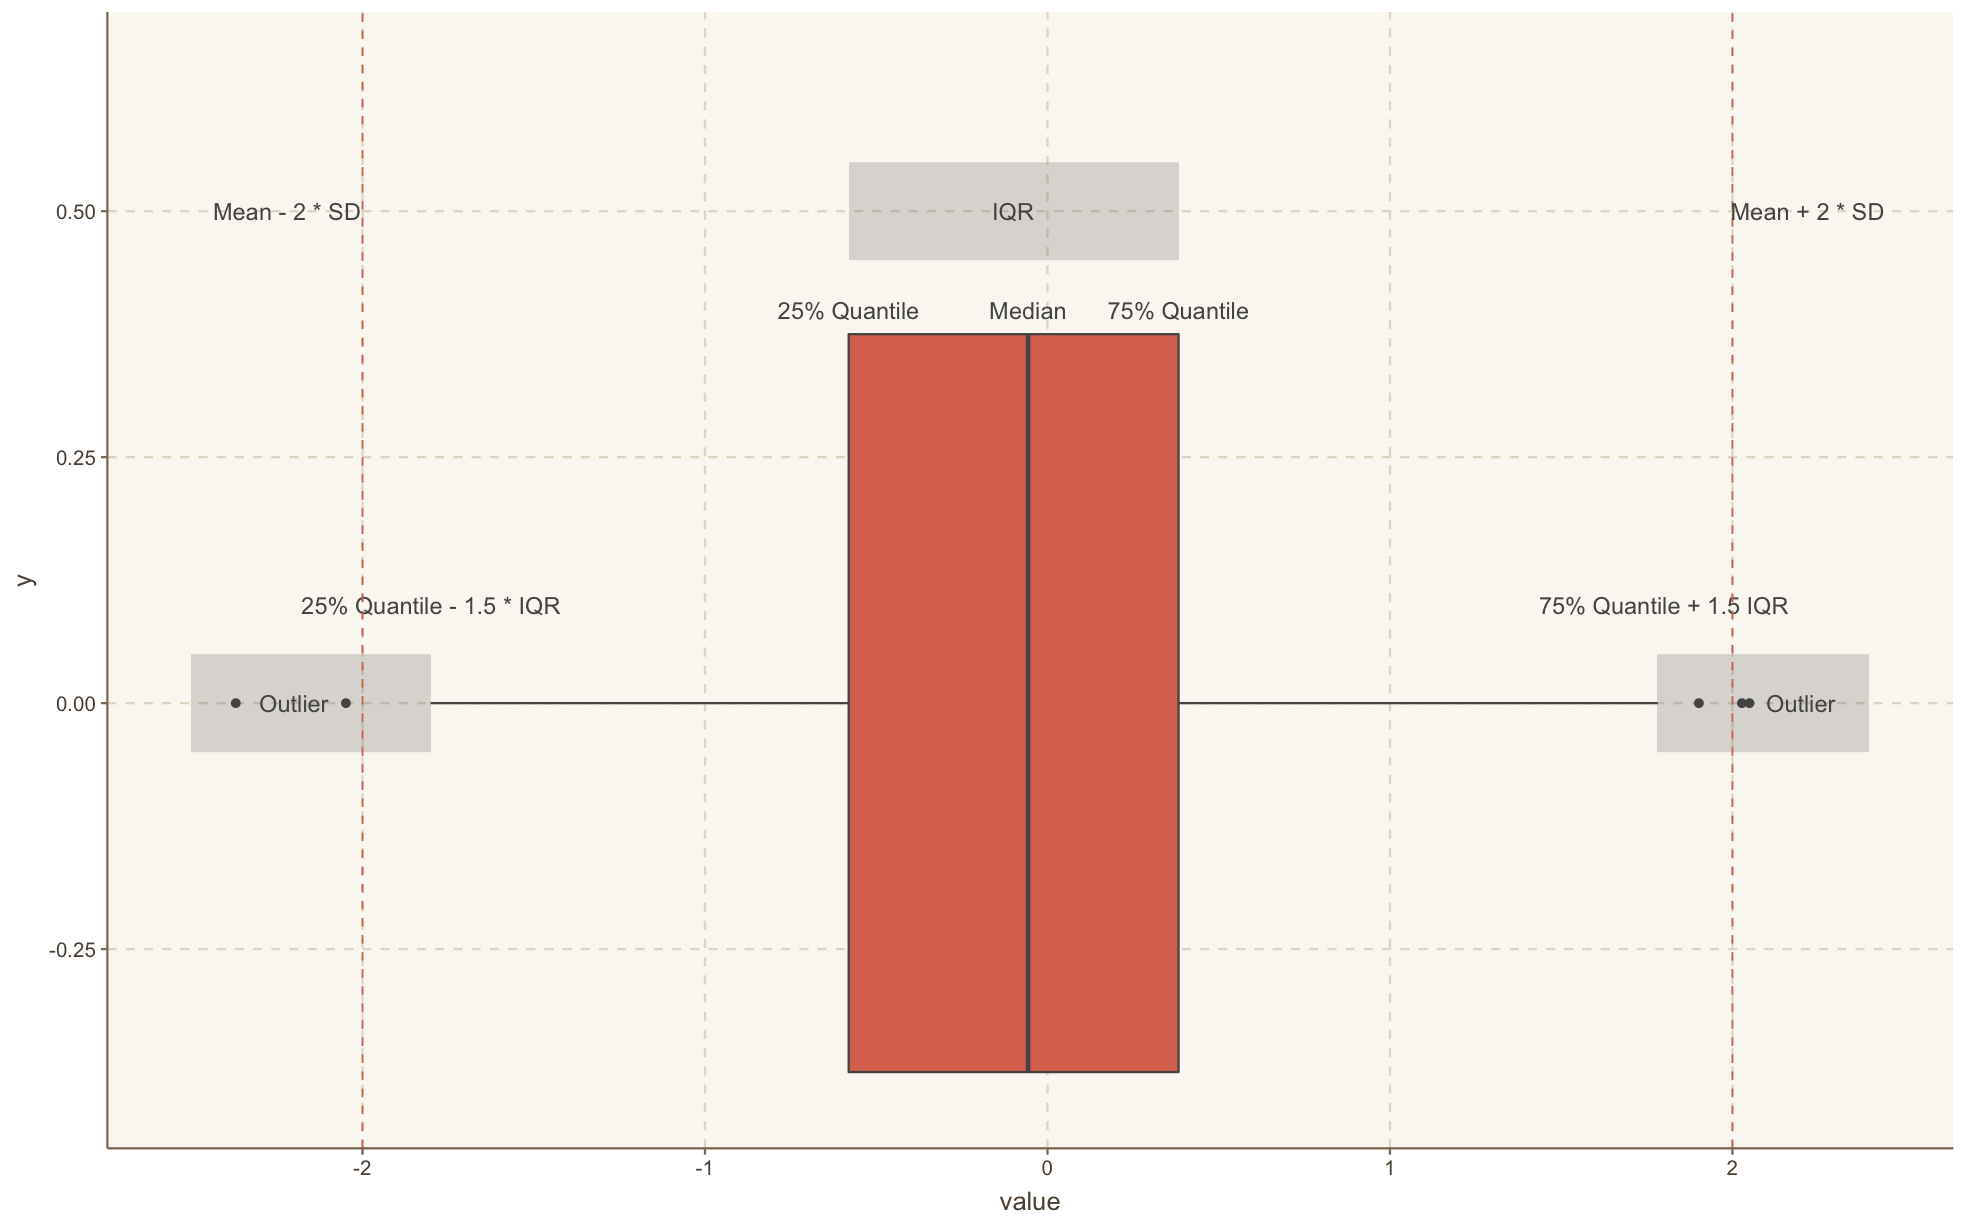

In [5]:
img = Image.open("data/boxplot.jpg")
img

In [24]:
cost_product_summary = pd.read_csv("data/cost_product_summary.csv")
cost_project_summary = pd.read_csv("data/cost_project_summary.csv")

Here is a screenshot of statistics summary for cost in different products and projects

In [25]:
pd.options.display.float_format = "{:.2f}".format
cost_product_summary

,product,number,mean,sd,median,min,max,quantile1,quantile3,iqr,inlier1,inlier3,no_of_outlier_iqr,no_of_outlier_sd
0,BigQuery,639,197.93,136.35,190.37,-823.08,1170.70,121.89,269.20,147.31,-99.08,490.18,9,14
1,Stackdriver Logging,639,69.61,107.30,31.06,-834.71,905.79,15.90,95.28,79.38,-103.16,214.34,59,30
2,Stackdriver Monitoring,639,4.18,10.46,0.00,0.00,91.37,0.00,2.34,2.34,-3.52,5.86,129,21
3,Support,639,91.26,76.71,77.20,-579.25,750.80,52.36,116.41,64.05,-43.72,212.48,34,18
4,Compute Engine,638,1091.27,843.84,932.34,-4910.10,7101.45,586.60,1459.51,872.91,-722.78,2768.88,24,24
5,Cloud DNS,627,7.89,5.16,7.98,-36.27,56.56,6.66,9.75,3.10,2.01,14.40,11,7
6,Cloud Storage,627,5.92,6.88,5.10,0.00,90.72,0.24,7.71,7.47,-10.96,18.92,32,32
7,Cloud Composer,477,38.88,28.64,50.56,-32.34,100.49,8.12,62.13,54.01,-72.90,143.15,0,1
8,Cloud Pub/Sub,402,0.06,0.12,0.01,0.00,1.19,0.00,0.08,0.08,-0.12,0.20,27,12
9,Source Repository,217,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0


In [26]:
cost_project_summary

,project,number,mean,sd,median,min,max,quantile1,quantile3,iqr,inlier1,inlier3,no_of_outlier_iqr,no_of_outlier_sd
0,Null,639,90.86,77.48,77.20,-579.25,750.80,51.98,116.41,64.42,-44.66,213.04,34,18
1,livescore-cloud,639,979.38,815.65,789.91,-5743.78,7947.96,601.18,1164.43,563.24,-243.68,2009.30,57,21
2,livescore-web,639,107.48,84.27,106.86,-509.38,781.10,59.47,147.59,88.12,-72.72,279.78,14,14
3,livescore-main,637,81.85,58.70,83.58,-361.89,853.62,65.29,94.53,29.24,21.43,138.39,23,7
4,livescore-dev-project,456,64.87,62.97,26.27,-66.50,345.99,22.75,119.44,96.68,-122.27,264.46,5,14
5,livescore-shared-vpc,408,4.05,2.92,3.49,0.00,29.09,3.16,4.28,1.12,1.48,5.96,19,10
6,livescore-staging,407,37.32,12.87,41.54,0.09,73.68,32.96,44.41,11.45,15.79,61.57,3,3
7,livescore-data-production,384,42.00,7.79,42.22,0.00,74.35,39.77,44.81,5.03,32.22,52.36,20,10
8,lsm-data-infra,303,56.25,21.99,53.03,0.00,162.95,47.77,62.41,14.65,25.79,84.39,30,9
9,ls-vb-composer-external,264,35.97,5.82,36.27,0.00,60.53,34.15,38.04,3.89,28.32,43.87,13,7


These two tables give us an overview about how daily cost distribute throughout the whole time interval when cost data are avaiable. However, if we are more interested in the previous-ten-day cost data. We can use the following SQL to generate a new table for projects with the number of outliers:

<pre>
WITH dailyCost AS (
SELECT 
  DATE(export_time) AS date,
  project.id AS project,
  SUM(Cost) AS cost
FROM
  `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
GROUP BY
  project, date
ORDER BY 
  project, date ASC
),

costSummary AS (
SELECT
  date,
  project,
  ROUND(cost, 2) AS cost,
  ROUND(AVG(cost) OVER (PARTITION BY project ORDER BY date ASC ROWS BETWEEN 11 PRECEDING and 1 PRECEDING), 2) AS avgCost,
  ROUND(STDDEV(cost) OVER (PARTITION BY project ORDER BY date ASC ROWS BETWEEN 11 PRECEDING and 1 PRECEDING), 2) AS sdCost
FROM 
  dailyCost
),

outlierCost AS (
SELECT
  date,
  project,
  cost,
  avgCost,
  sdCost,
  ROUND(avgCost + 2 * sdCost, 2) AS threshold,
  IF (cost > avgCost + 2 * sdCost, 1, 0) AS outlier
FROM
  costSummary
)

SELECT
  project,
  SUM(outlier) AS noOutlier
FROM 
  outlierCost
GROUP BY 
  project
ORDER BY 
  project ASC
</pre>

The output is shown in the following.

In [6]:
bigquery_client.query(QUERY_RECENT).to_dataframe()

,project,noOutlier
0,None,66
1,cit-core-project,0
2,gamesys-eu-dev-sbtech-data,22
3,gamesys-eu-dev-sbtech-insight,25
4,gamesys-eu-live-sbtech-data,13
5,gamesys-eu-live-sbtech-insight,21
6,gamesys-eu-pp-sb-cloud,0
7,gamesys-eu-pp01-sb-cloud,0
8,gamesys-eu-prod-m-ink-sbtech,14
9,gamesys-eu-test-ei-253119,1


Besides these statistics summary, we want to include the bar plot in terms of cost in <b>main products and projects (top 5)</b> in 2020 and highlight two specific outlier detection metrics <b>(75% Quantile + 1.5IQR and Mean + 2SD)</b>. Main products and projects are provided as follow:

Product:
<ol>
    <li> Compute Engine
    <li> Stackdriver Logging
    <li> Stackdriver Monitoring
    <li> BigQuery
    <li> Support
</ol>

Project:
<ol>
    <li> None id
    <li> livescore-cloud
    <li> livescore-web
    <li> livescore-main
    <li> livescore-dev-project
</ol>

Note that statistics summary are calculated based on the <b>population data</b> rather than sample data from 2020 and not excluding <b>negative costs</b>. It is possible that some products or projects do not have outliers in 2020 (e.g. Stackdriver Logging). On the other hand, costs in Stackdriver Monitoring in 2020 are almost outliers given these two metrics with merely four inliers in this time interval. 

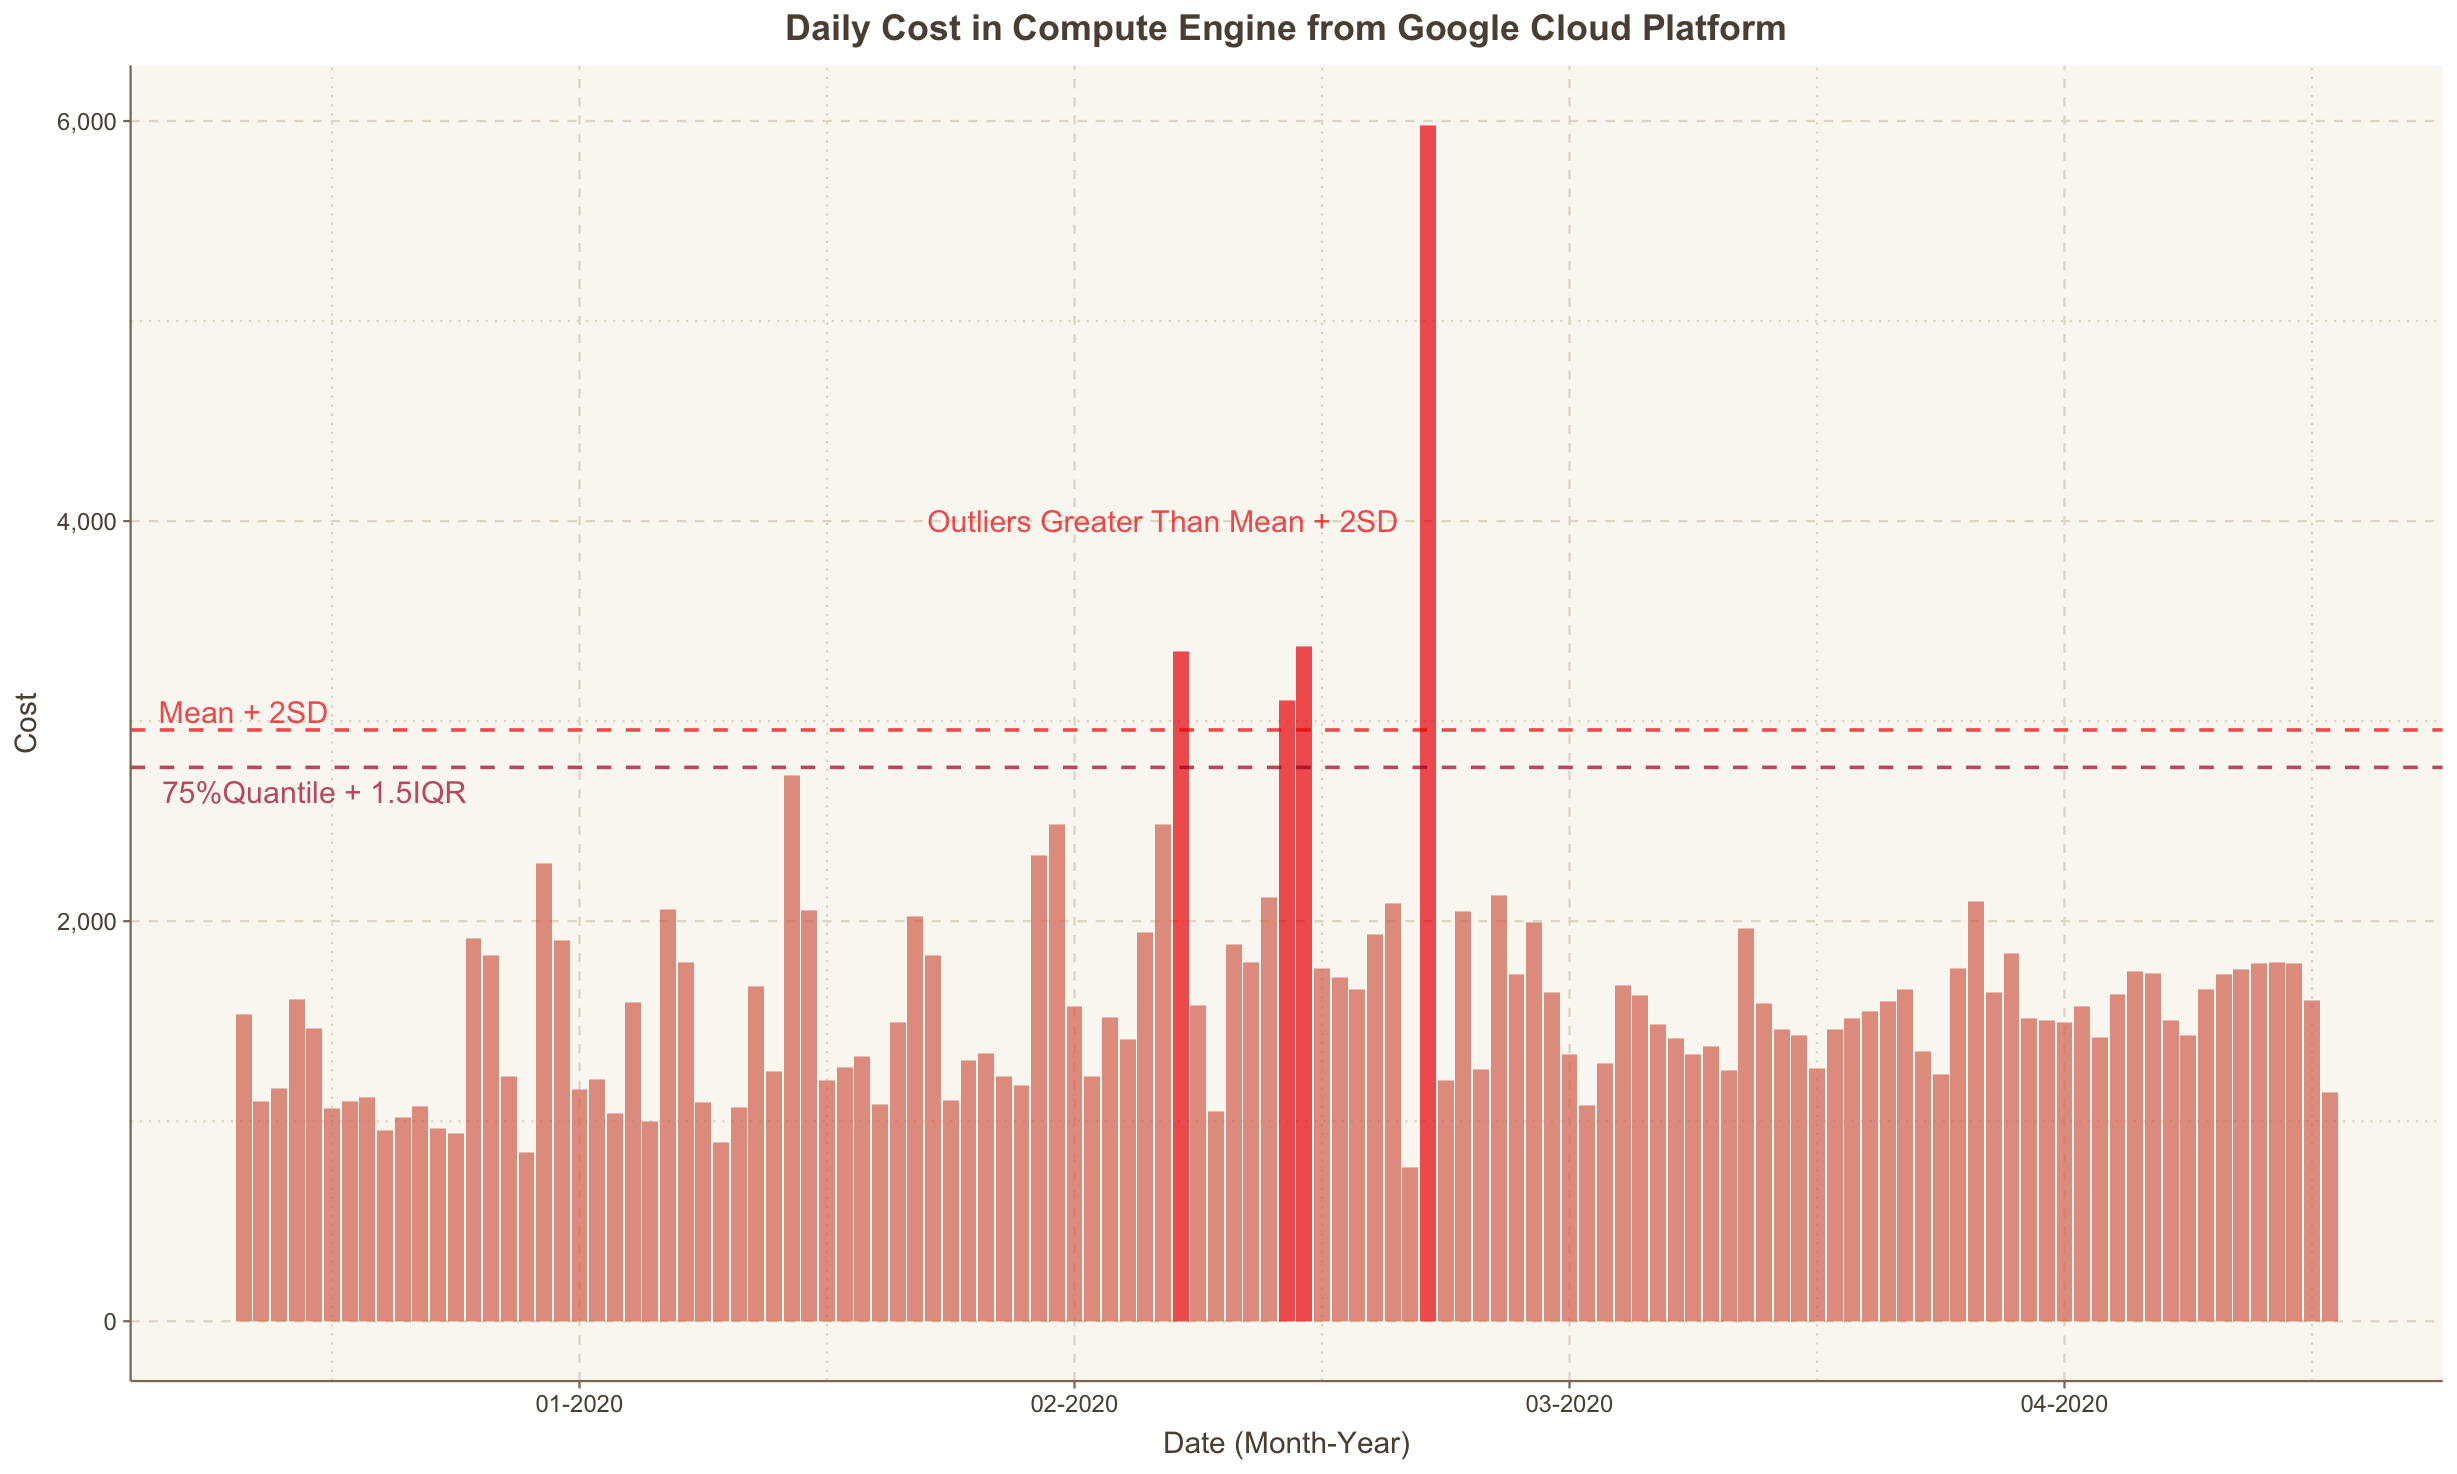

In [2]:
img = Image.open("image/compute_engine.png")
img

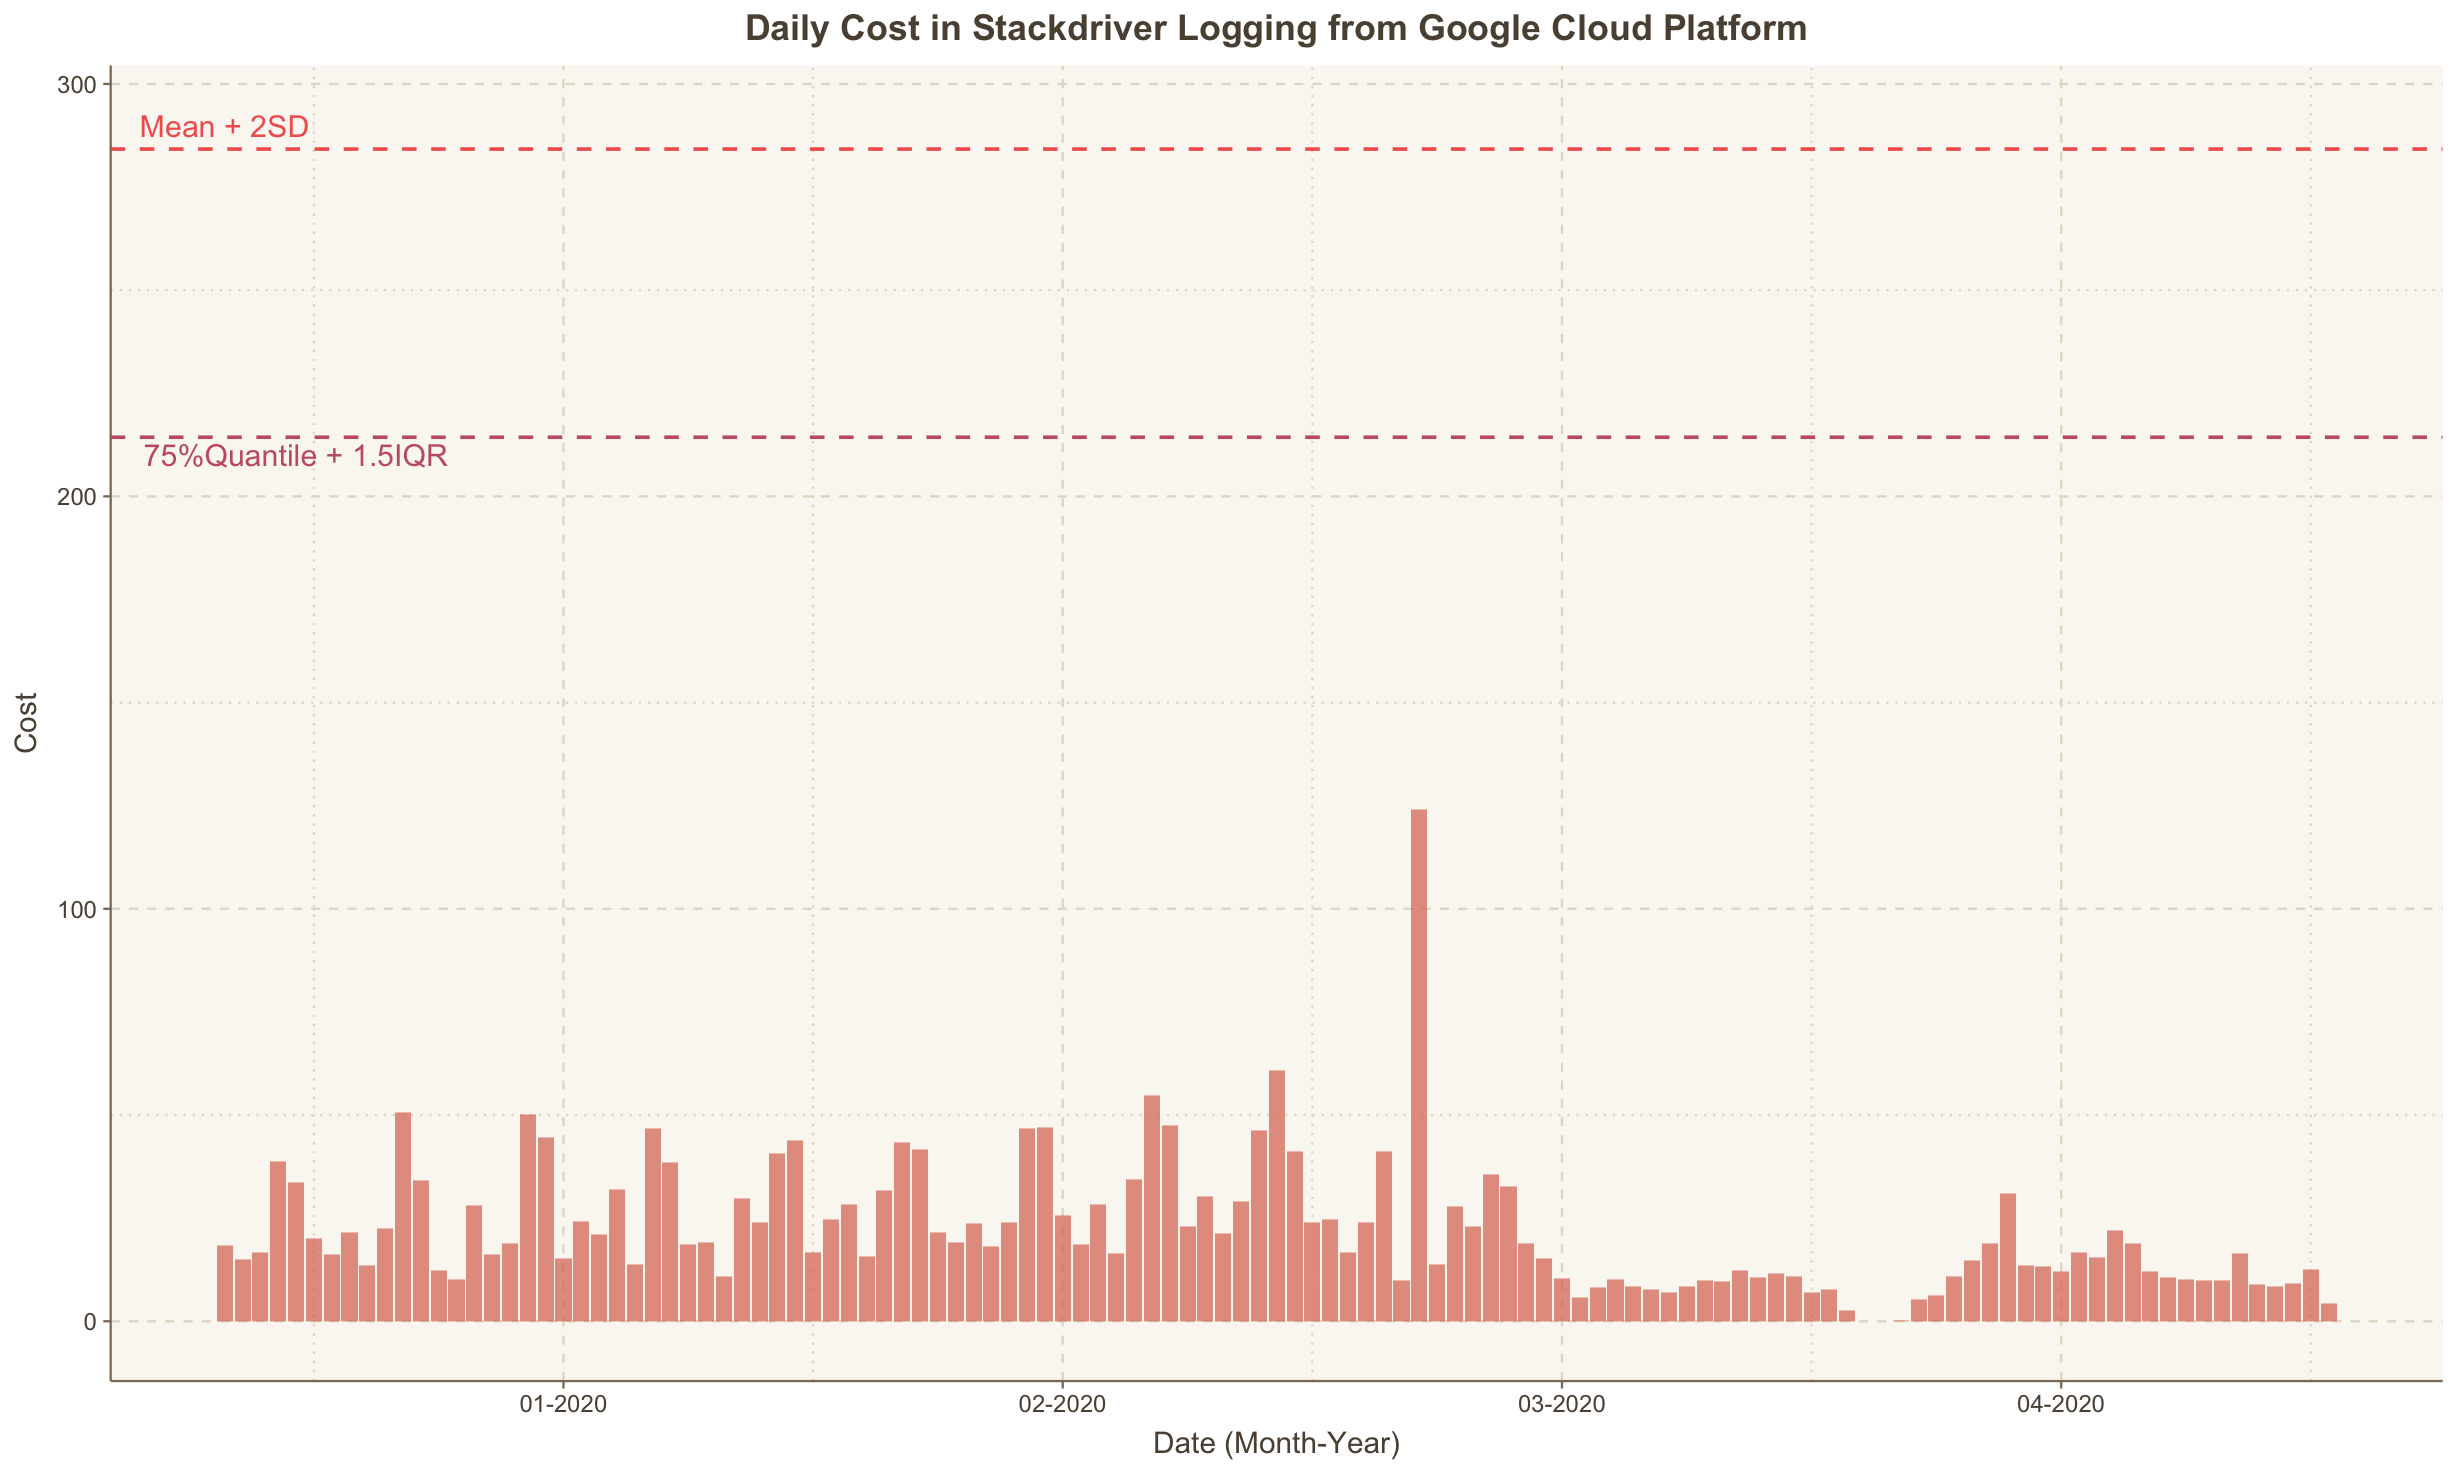

In [3]:
img = Image.open("image/stack_logging.png")
img

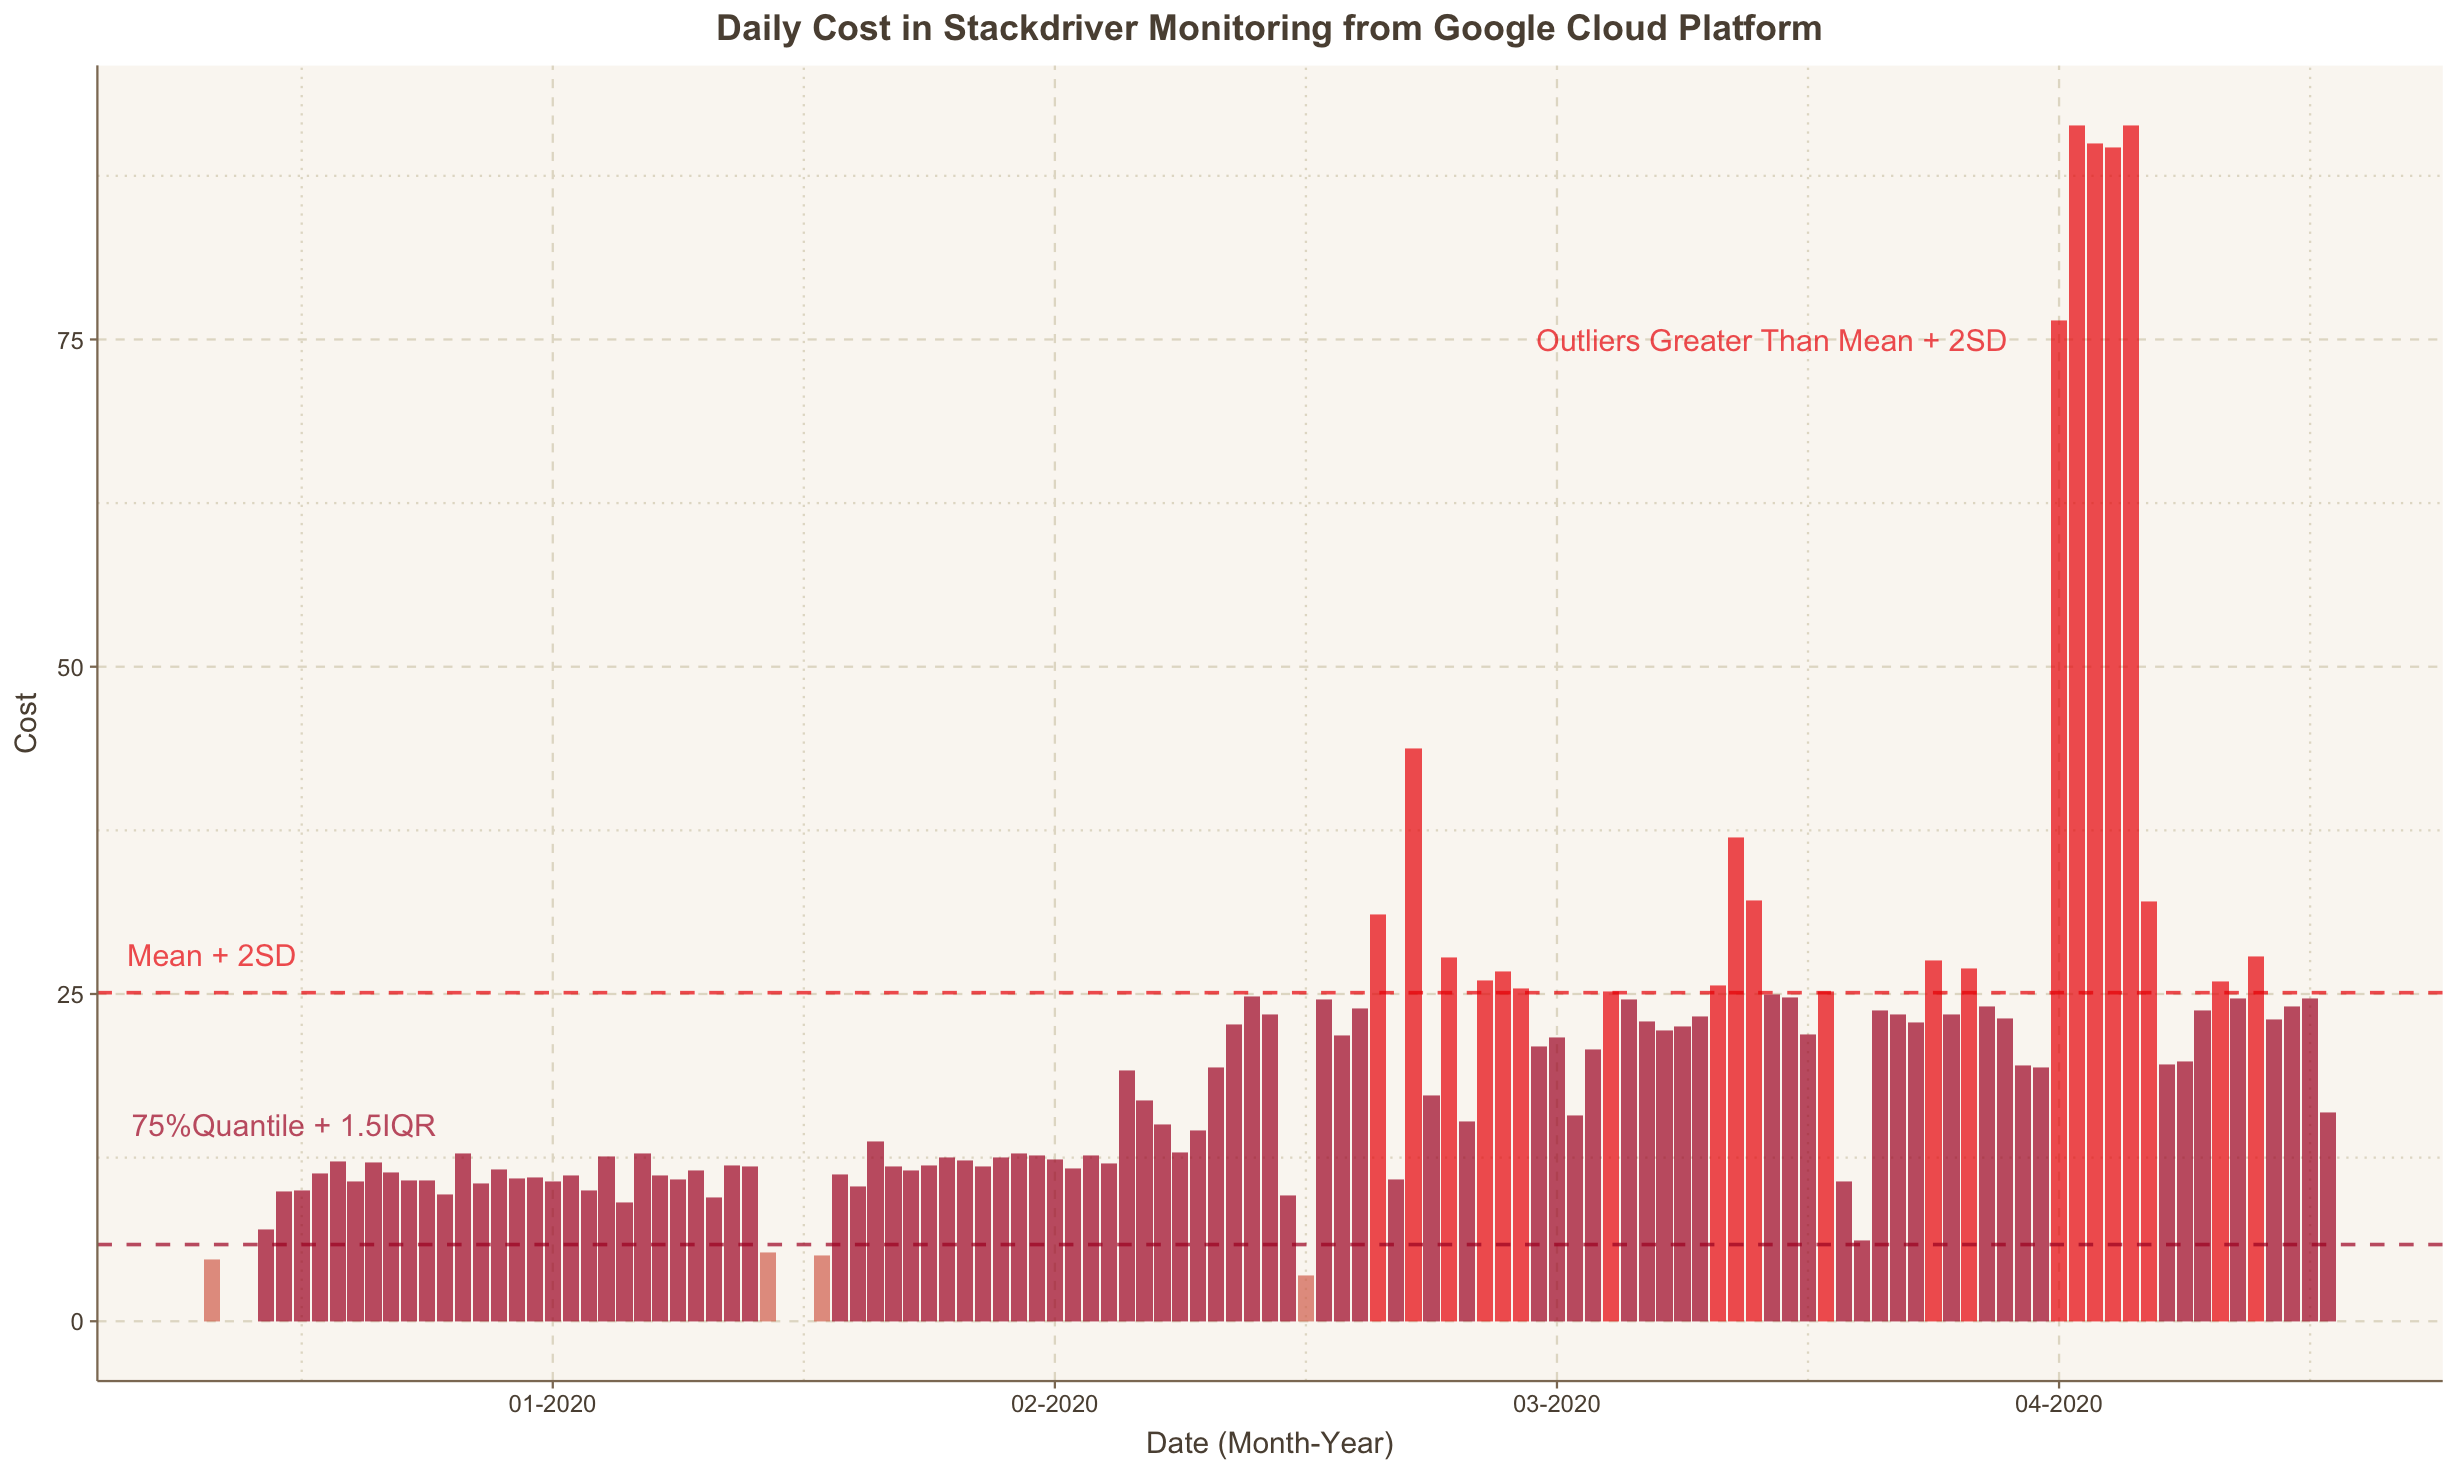

In [4]:
img = Image.open("image/stack_monitor.png")
img

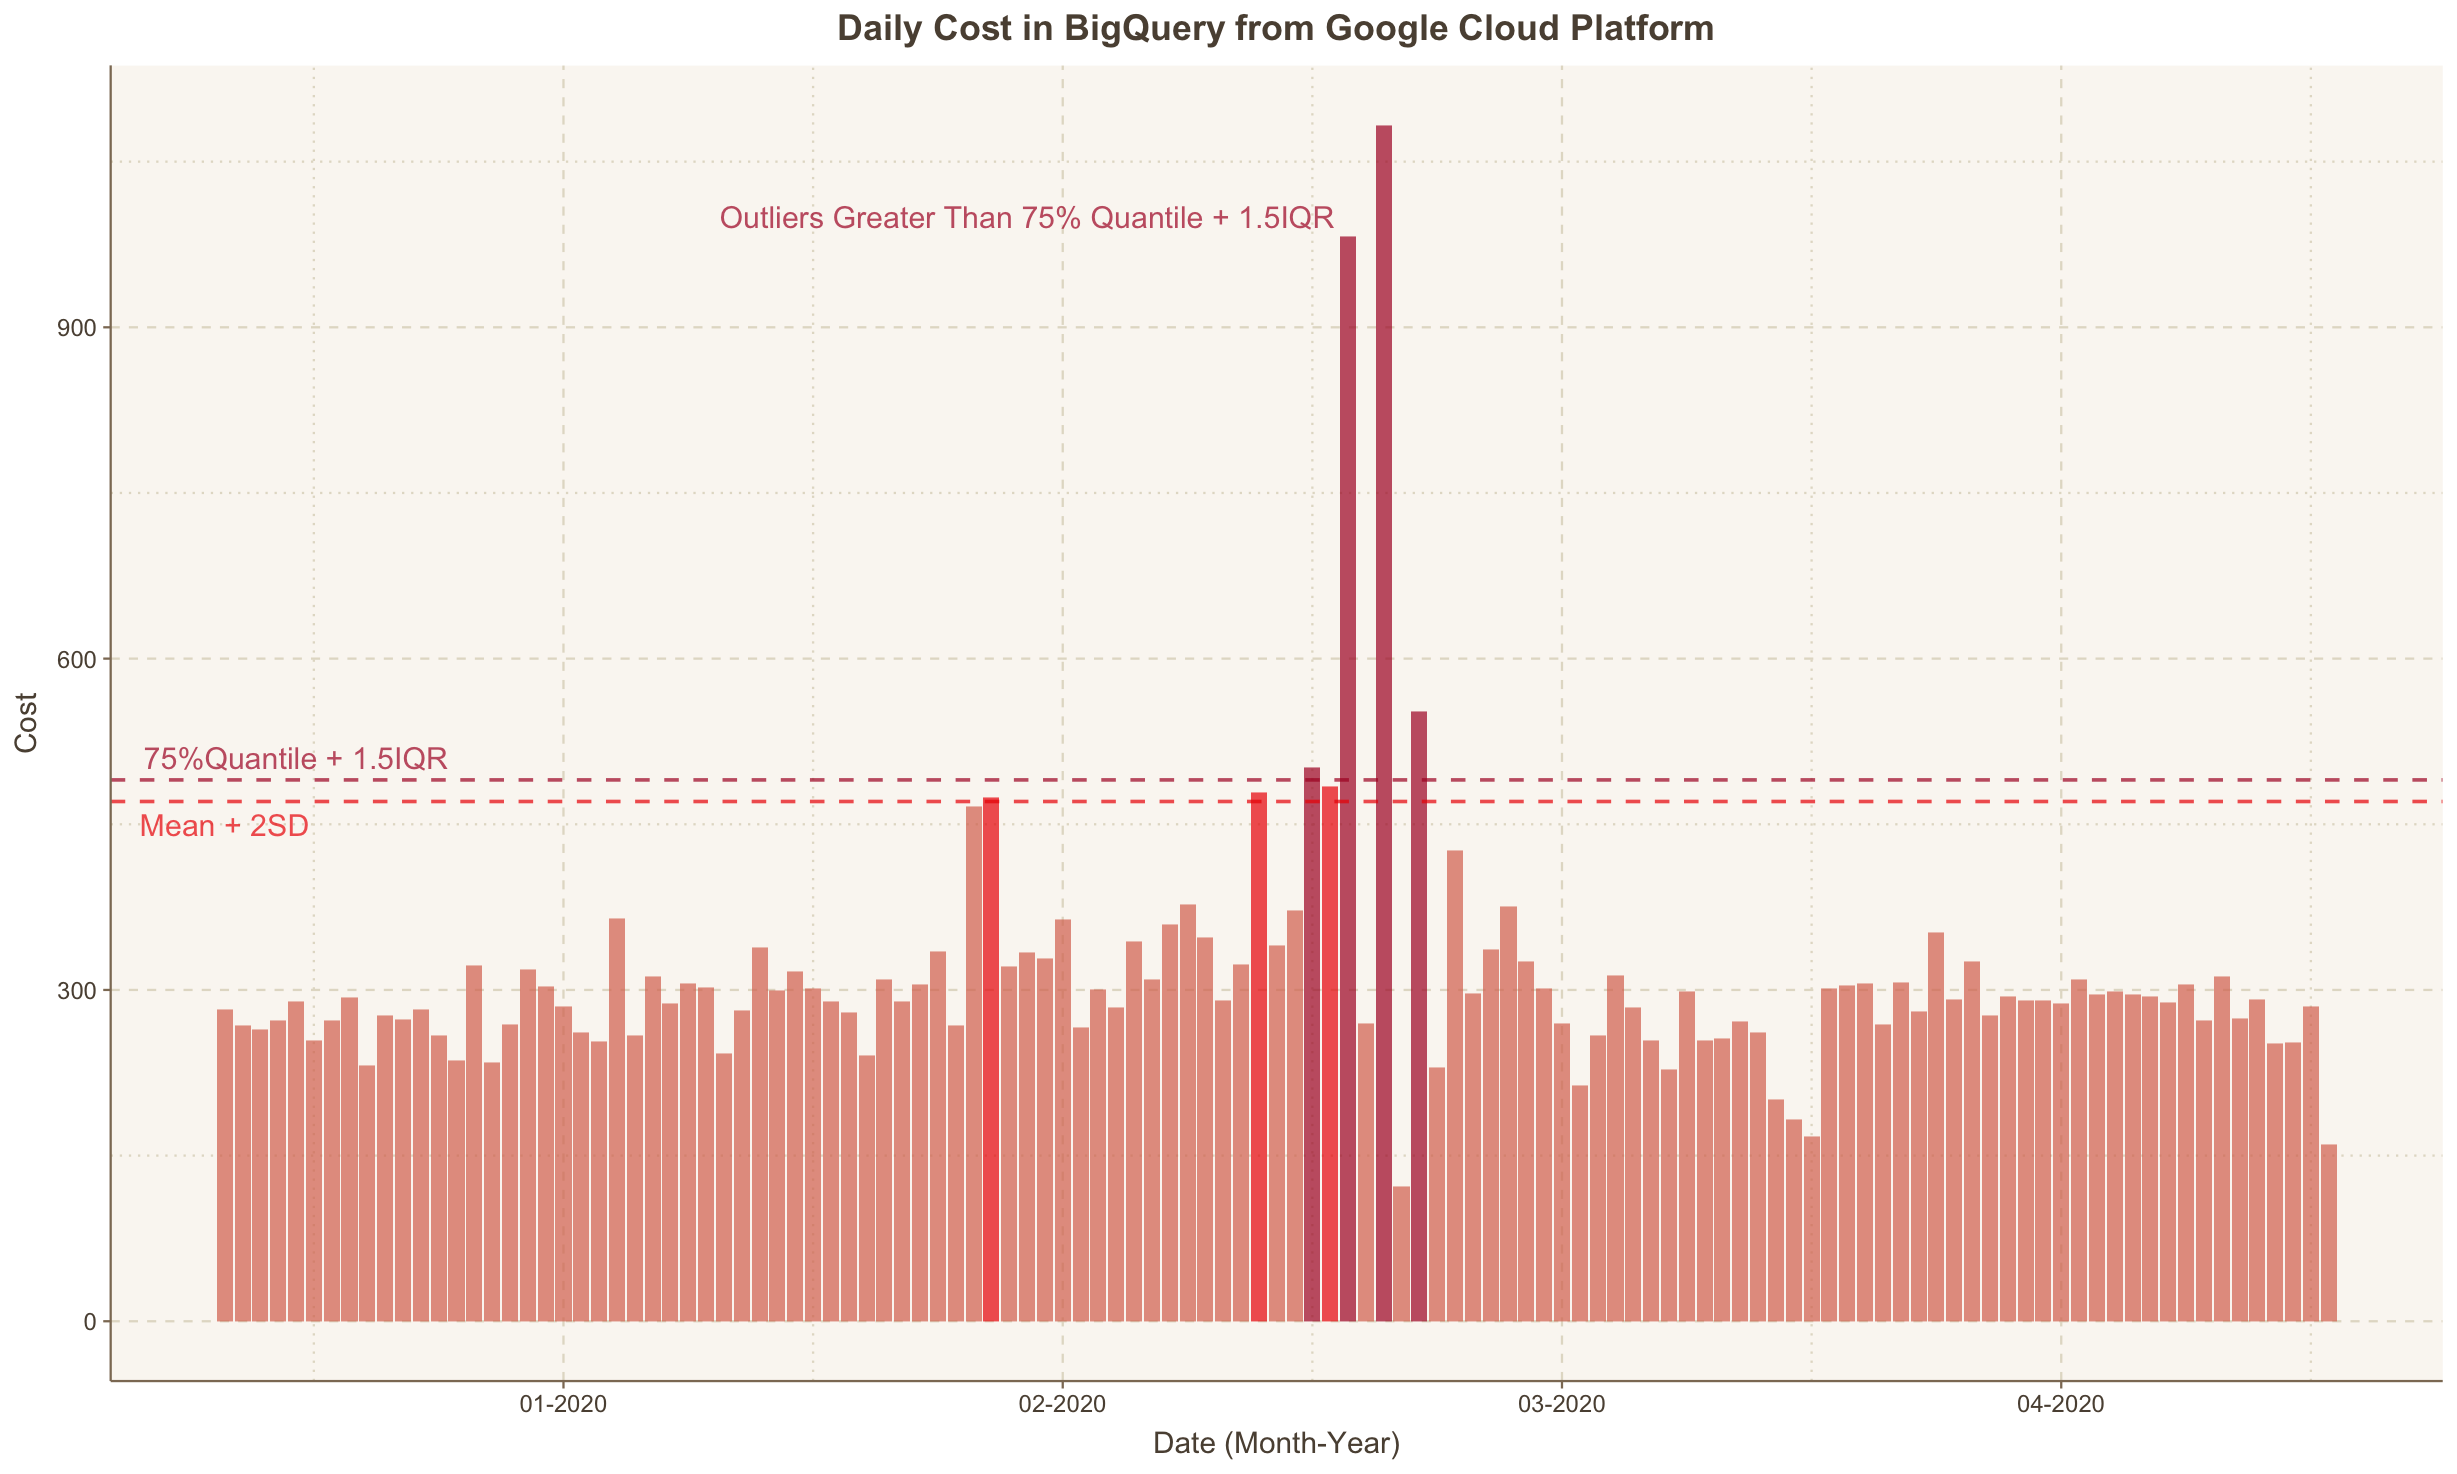

In [5]:
img = Image.open("image/bq_cost.png")
img

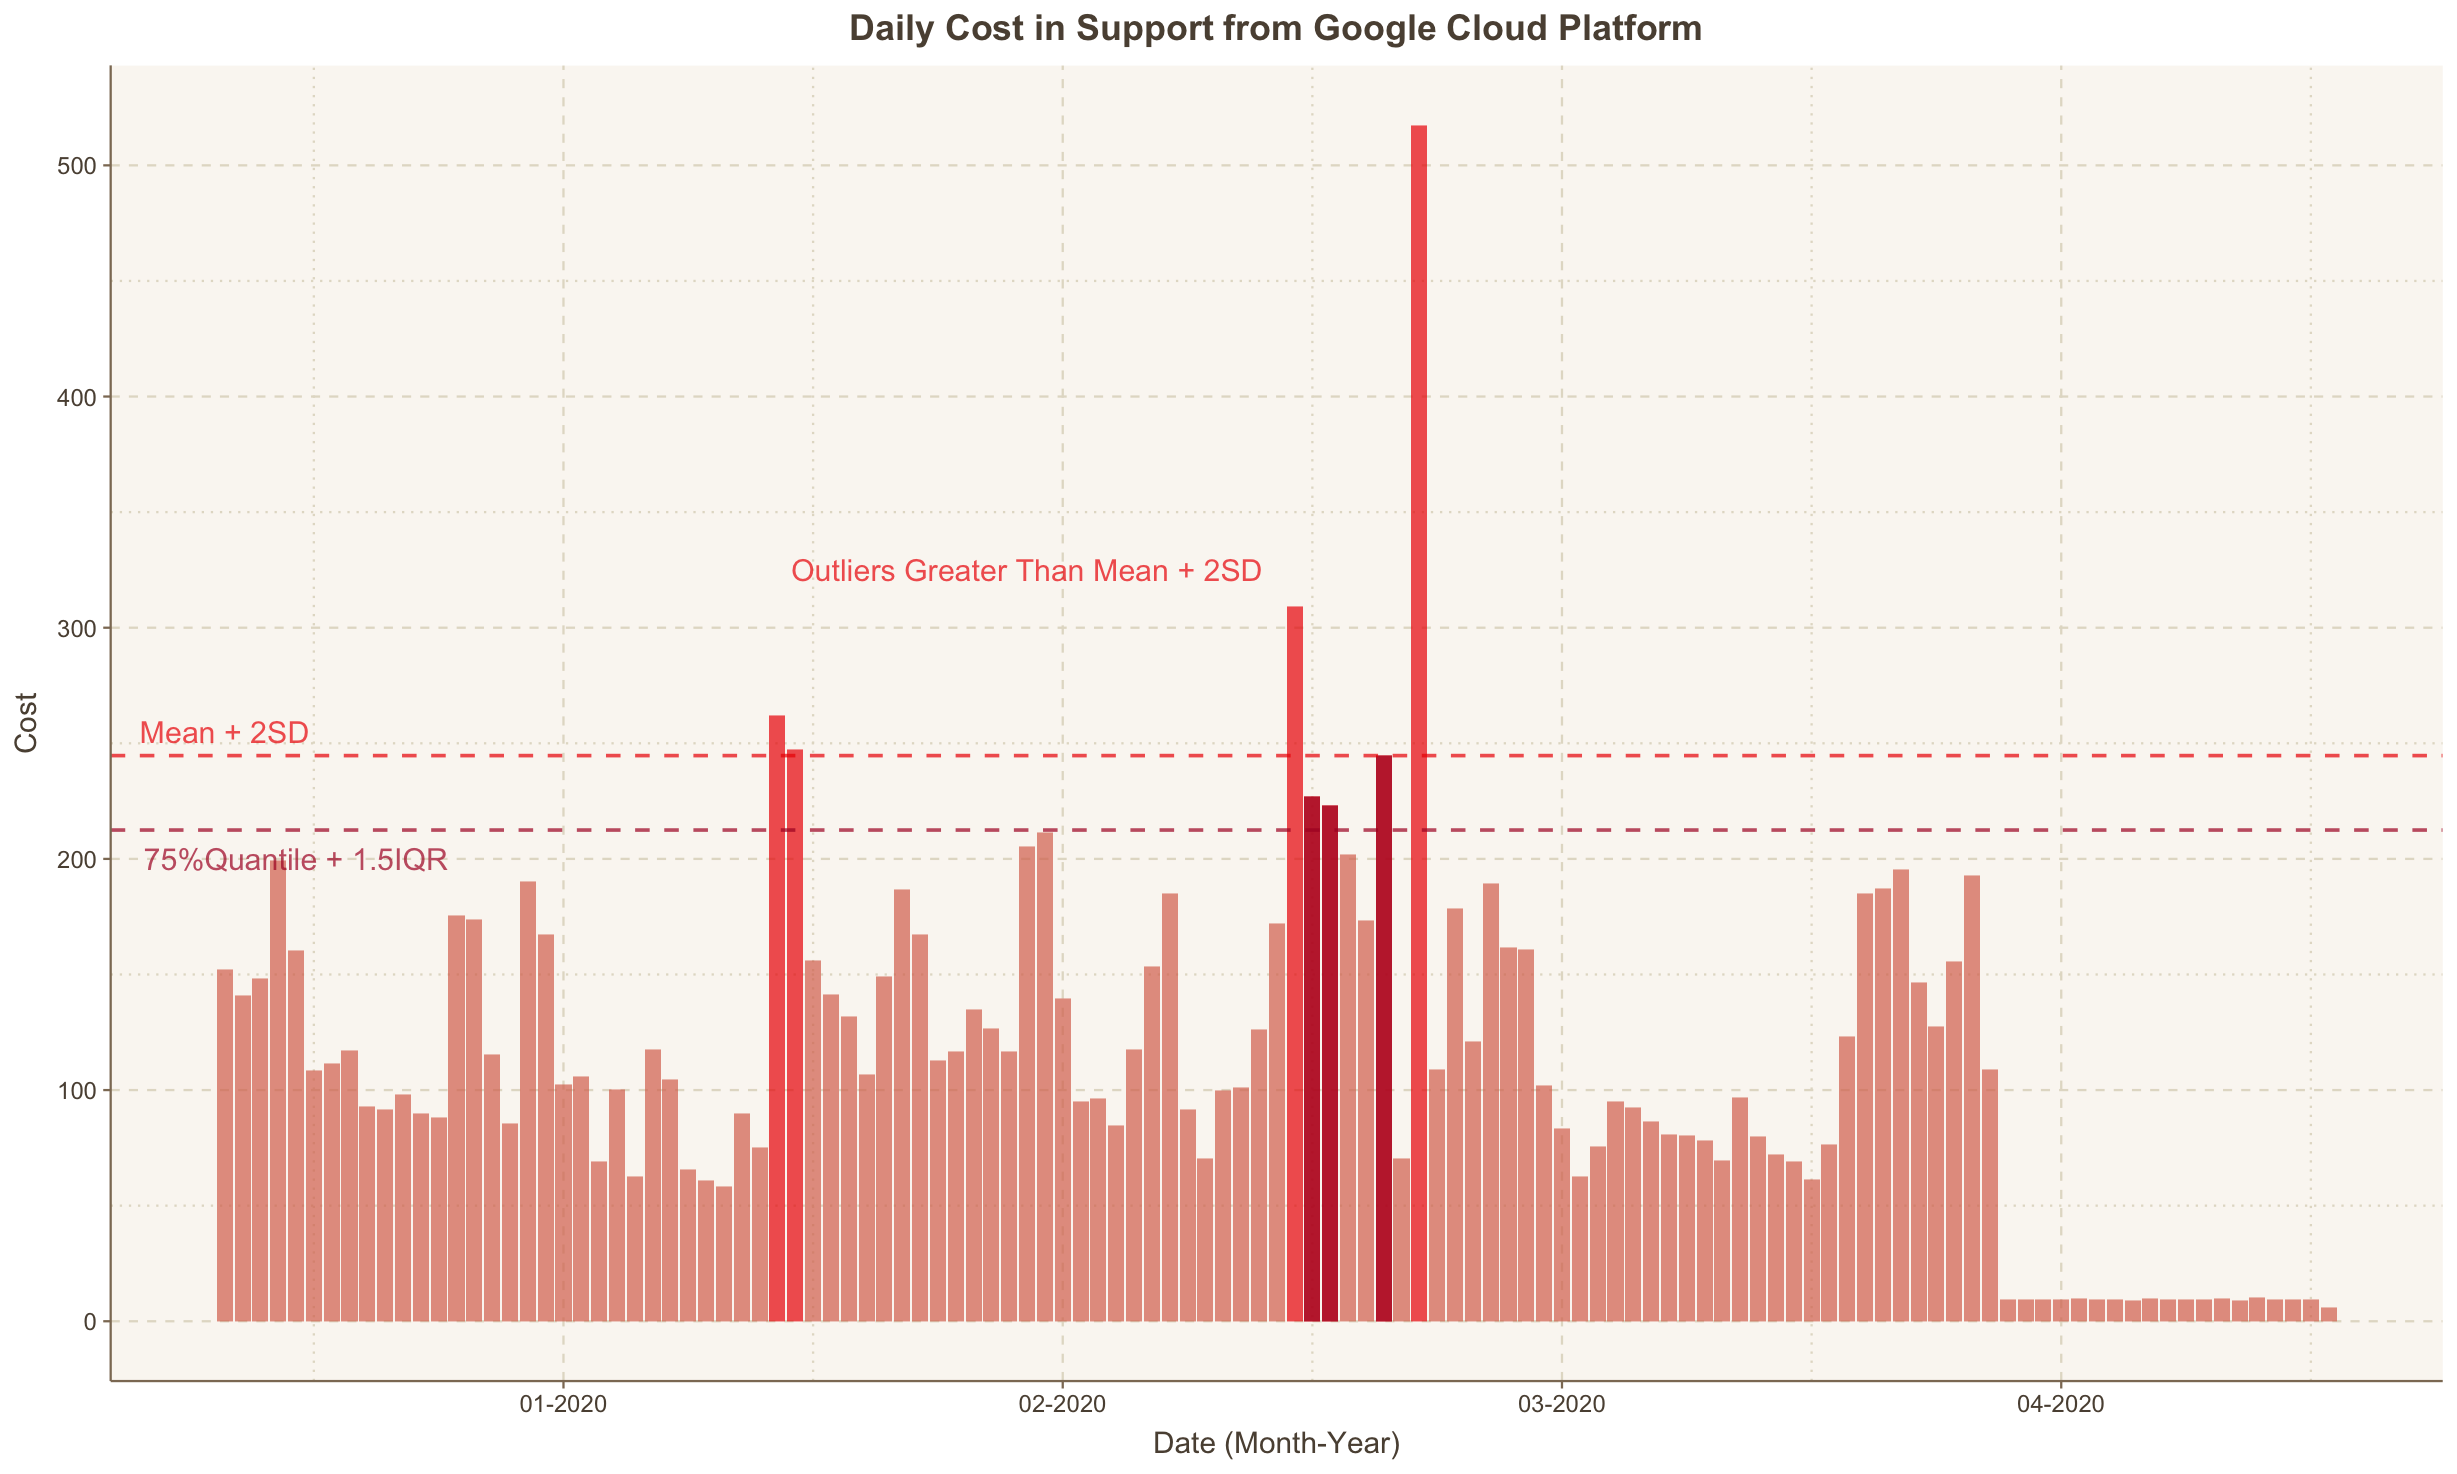

In [6]:
img = Image.open("image/support.png")
img

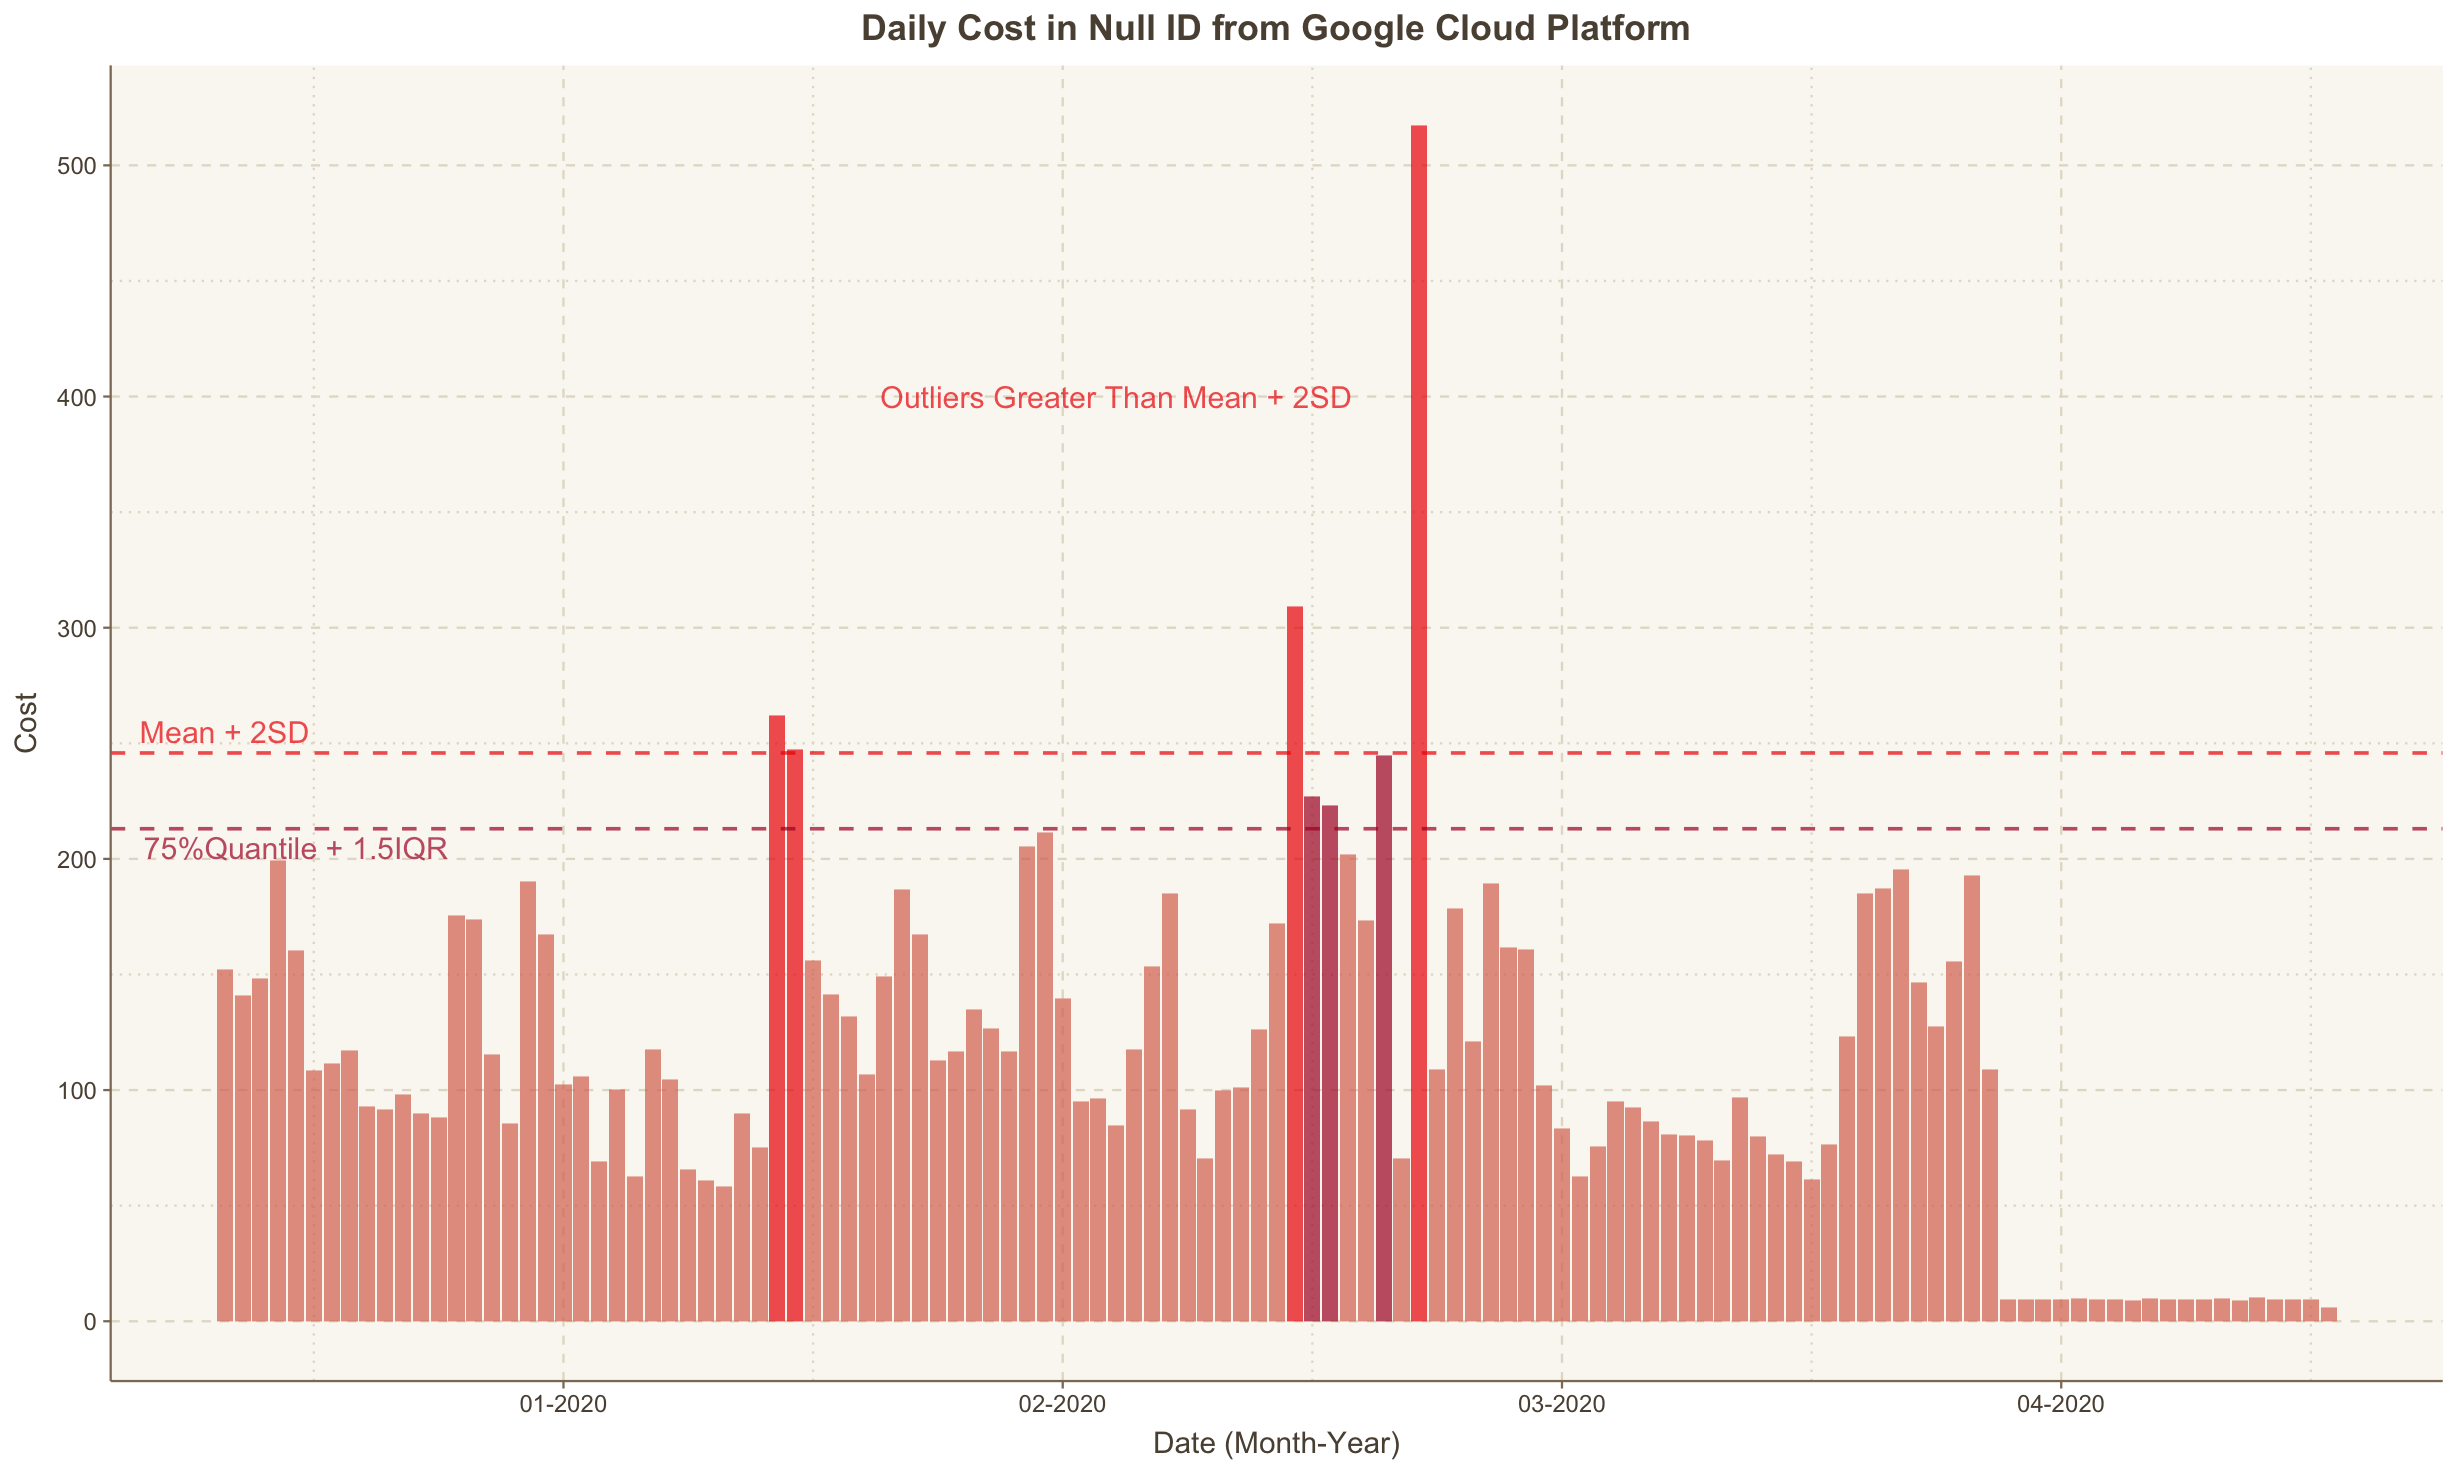

In [7]:
img = Image.open("image/null_id.png")
img

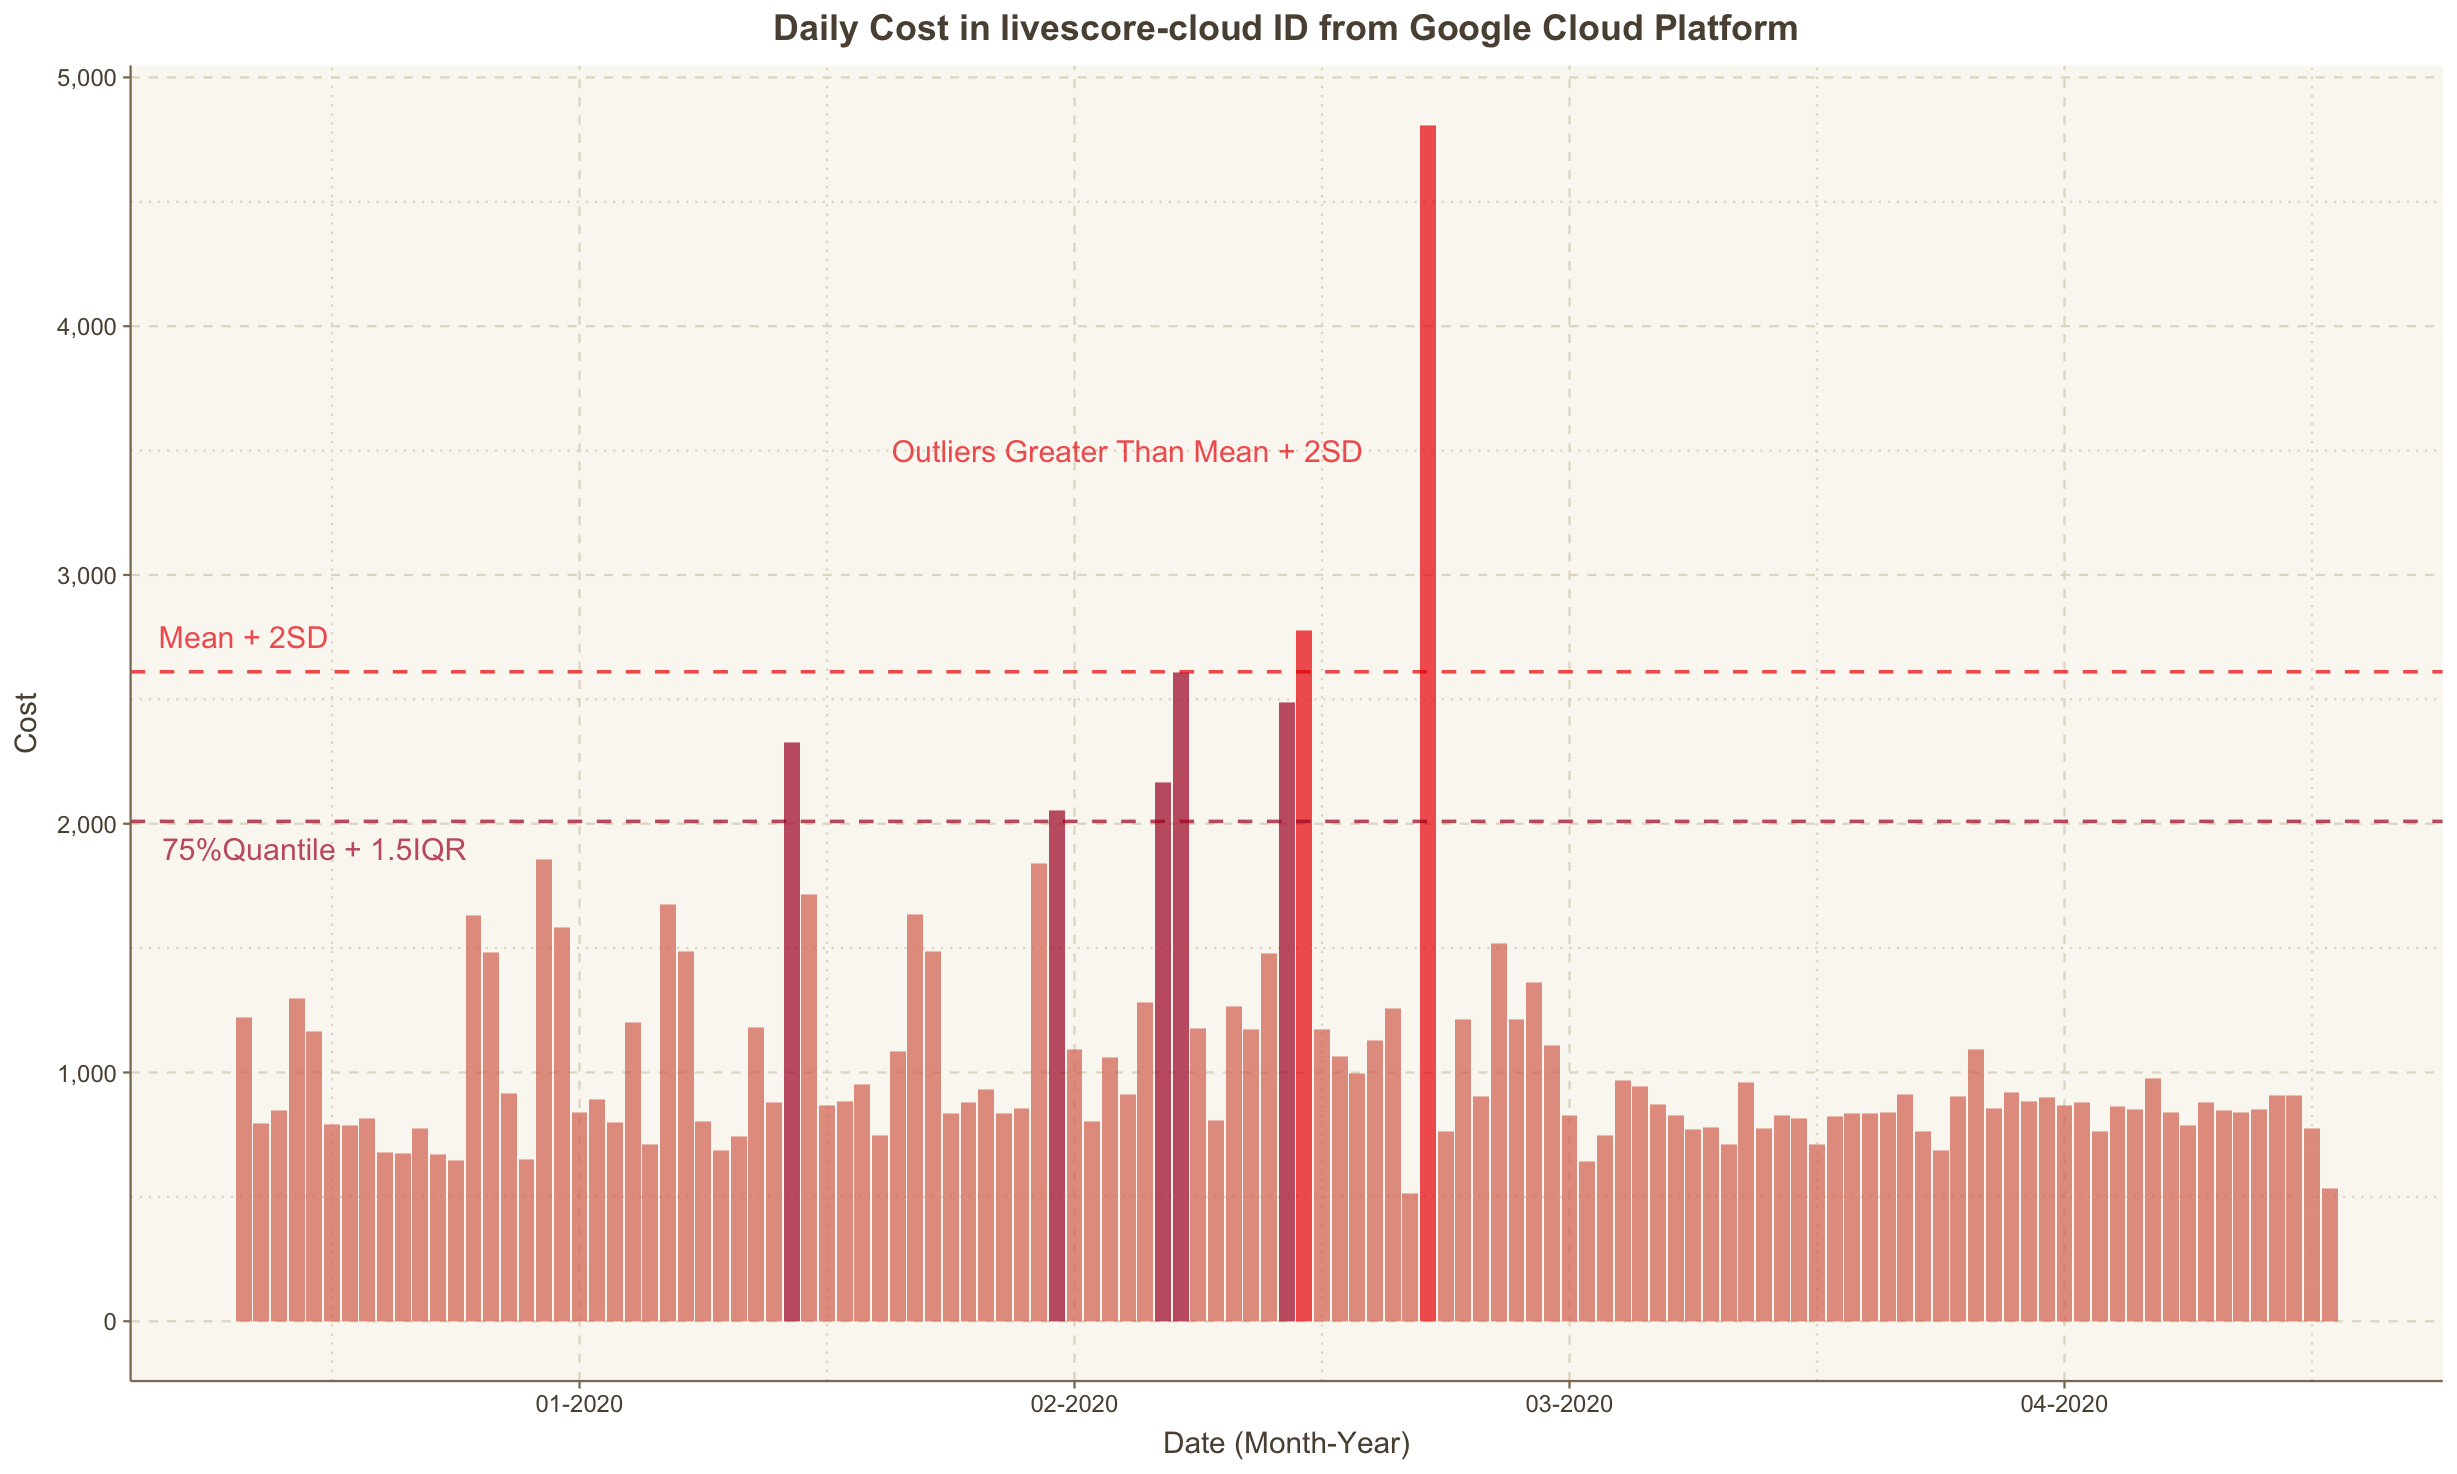

In [8]:
img = Image.open("image/livescore_cloud.png")
img

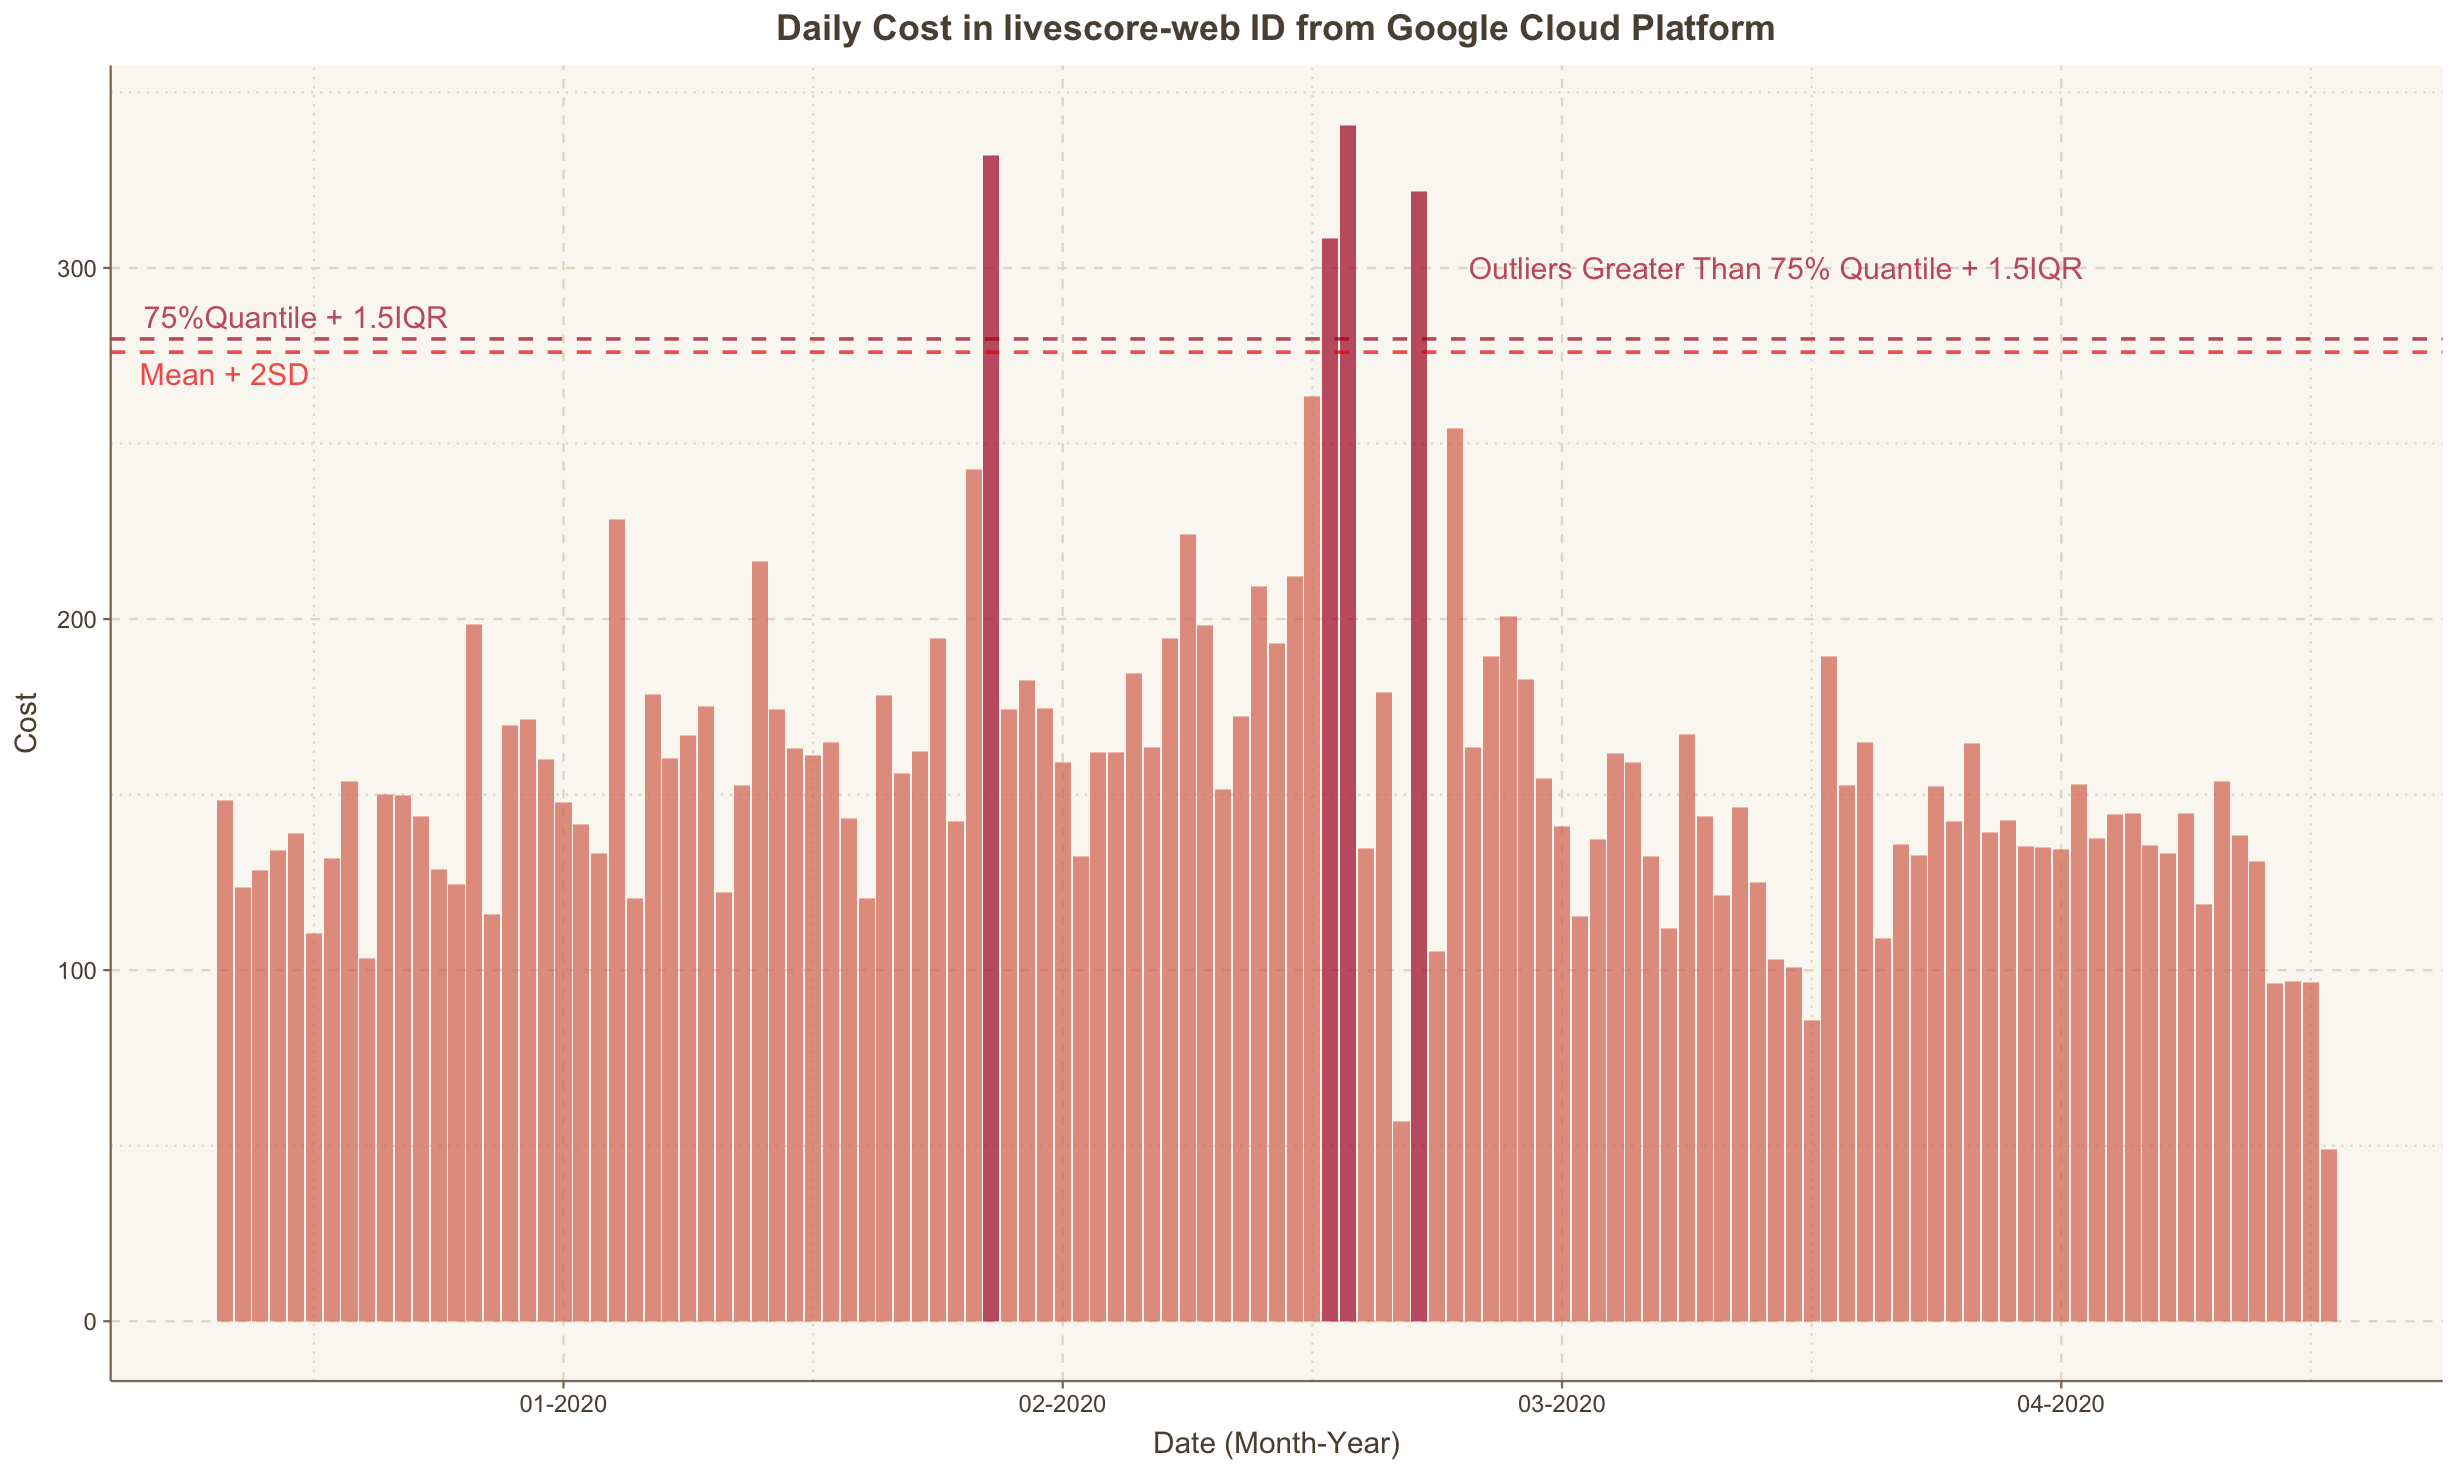

In [9]:
img = Image.open("image/livescore_web.png")
img

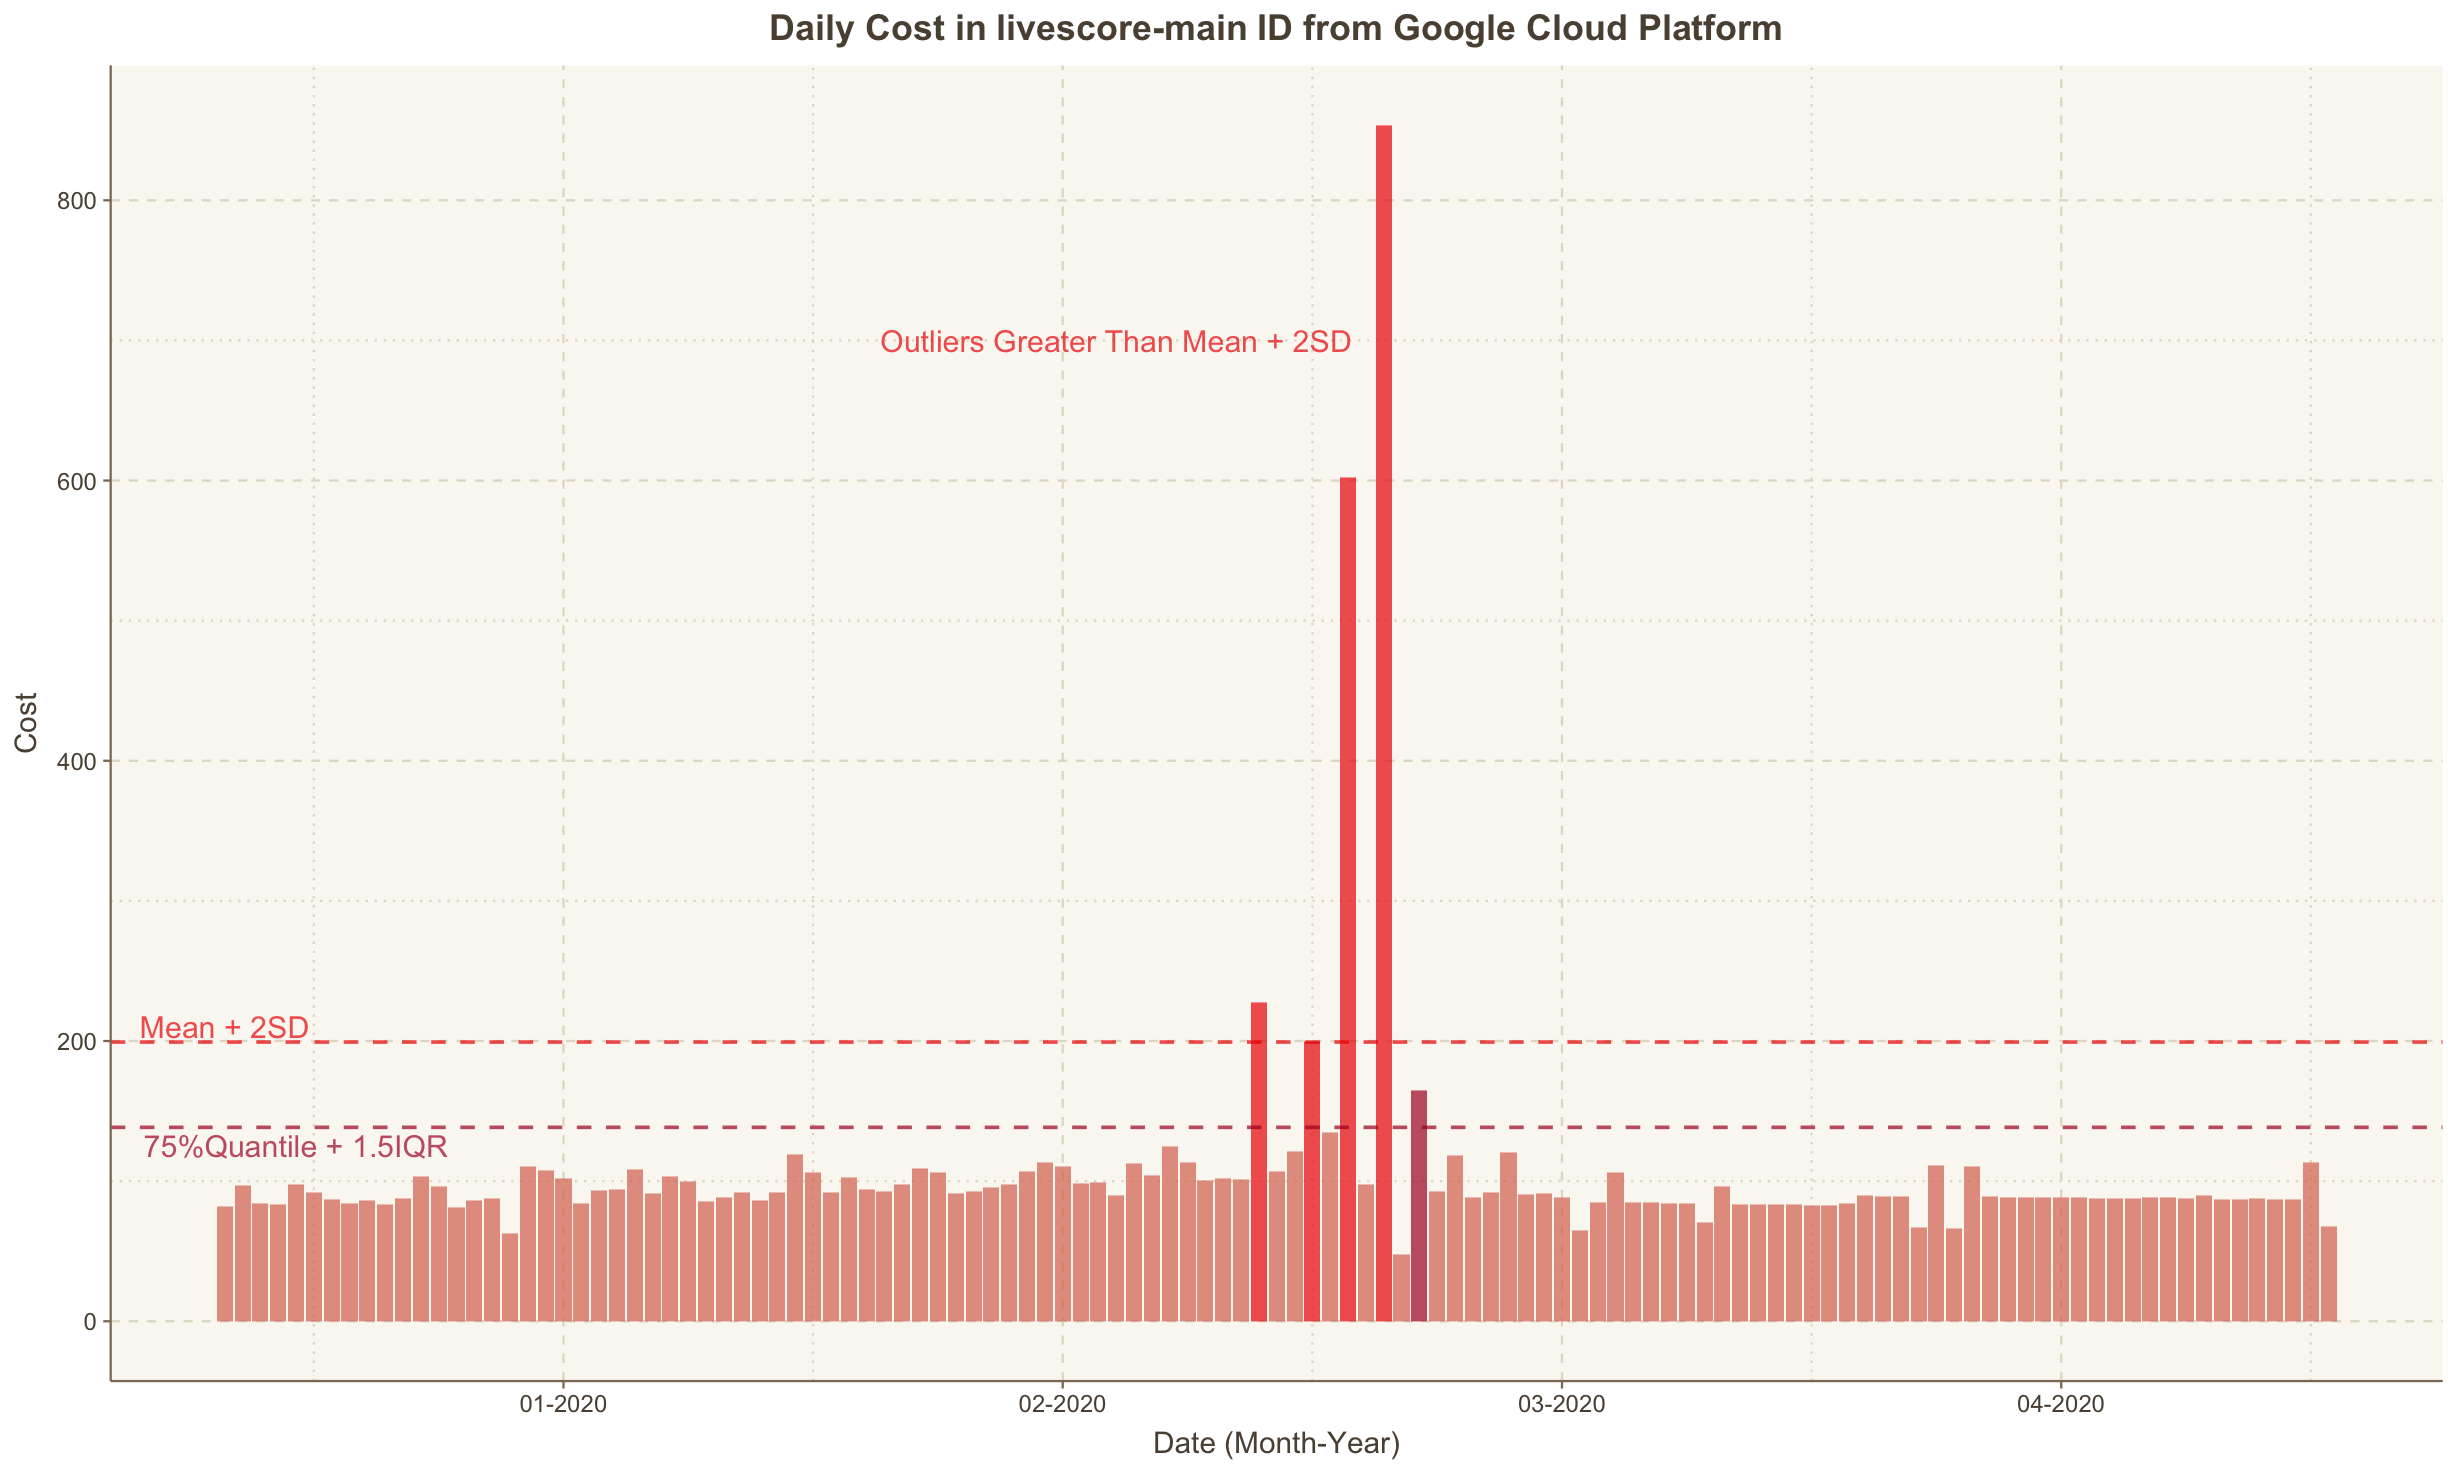

In [10]:
img = Image.open("image/livescore_main.png")
img

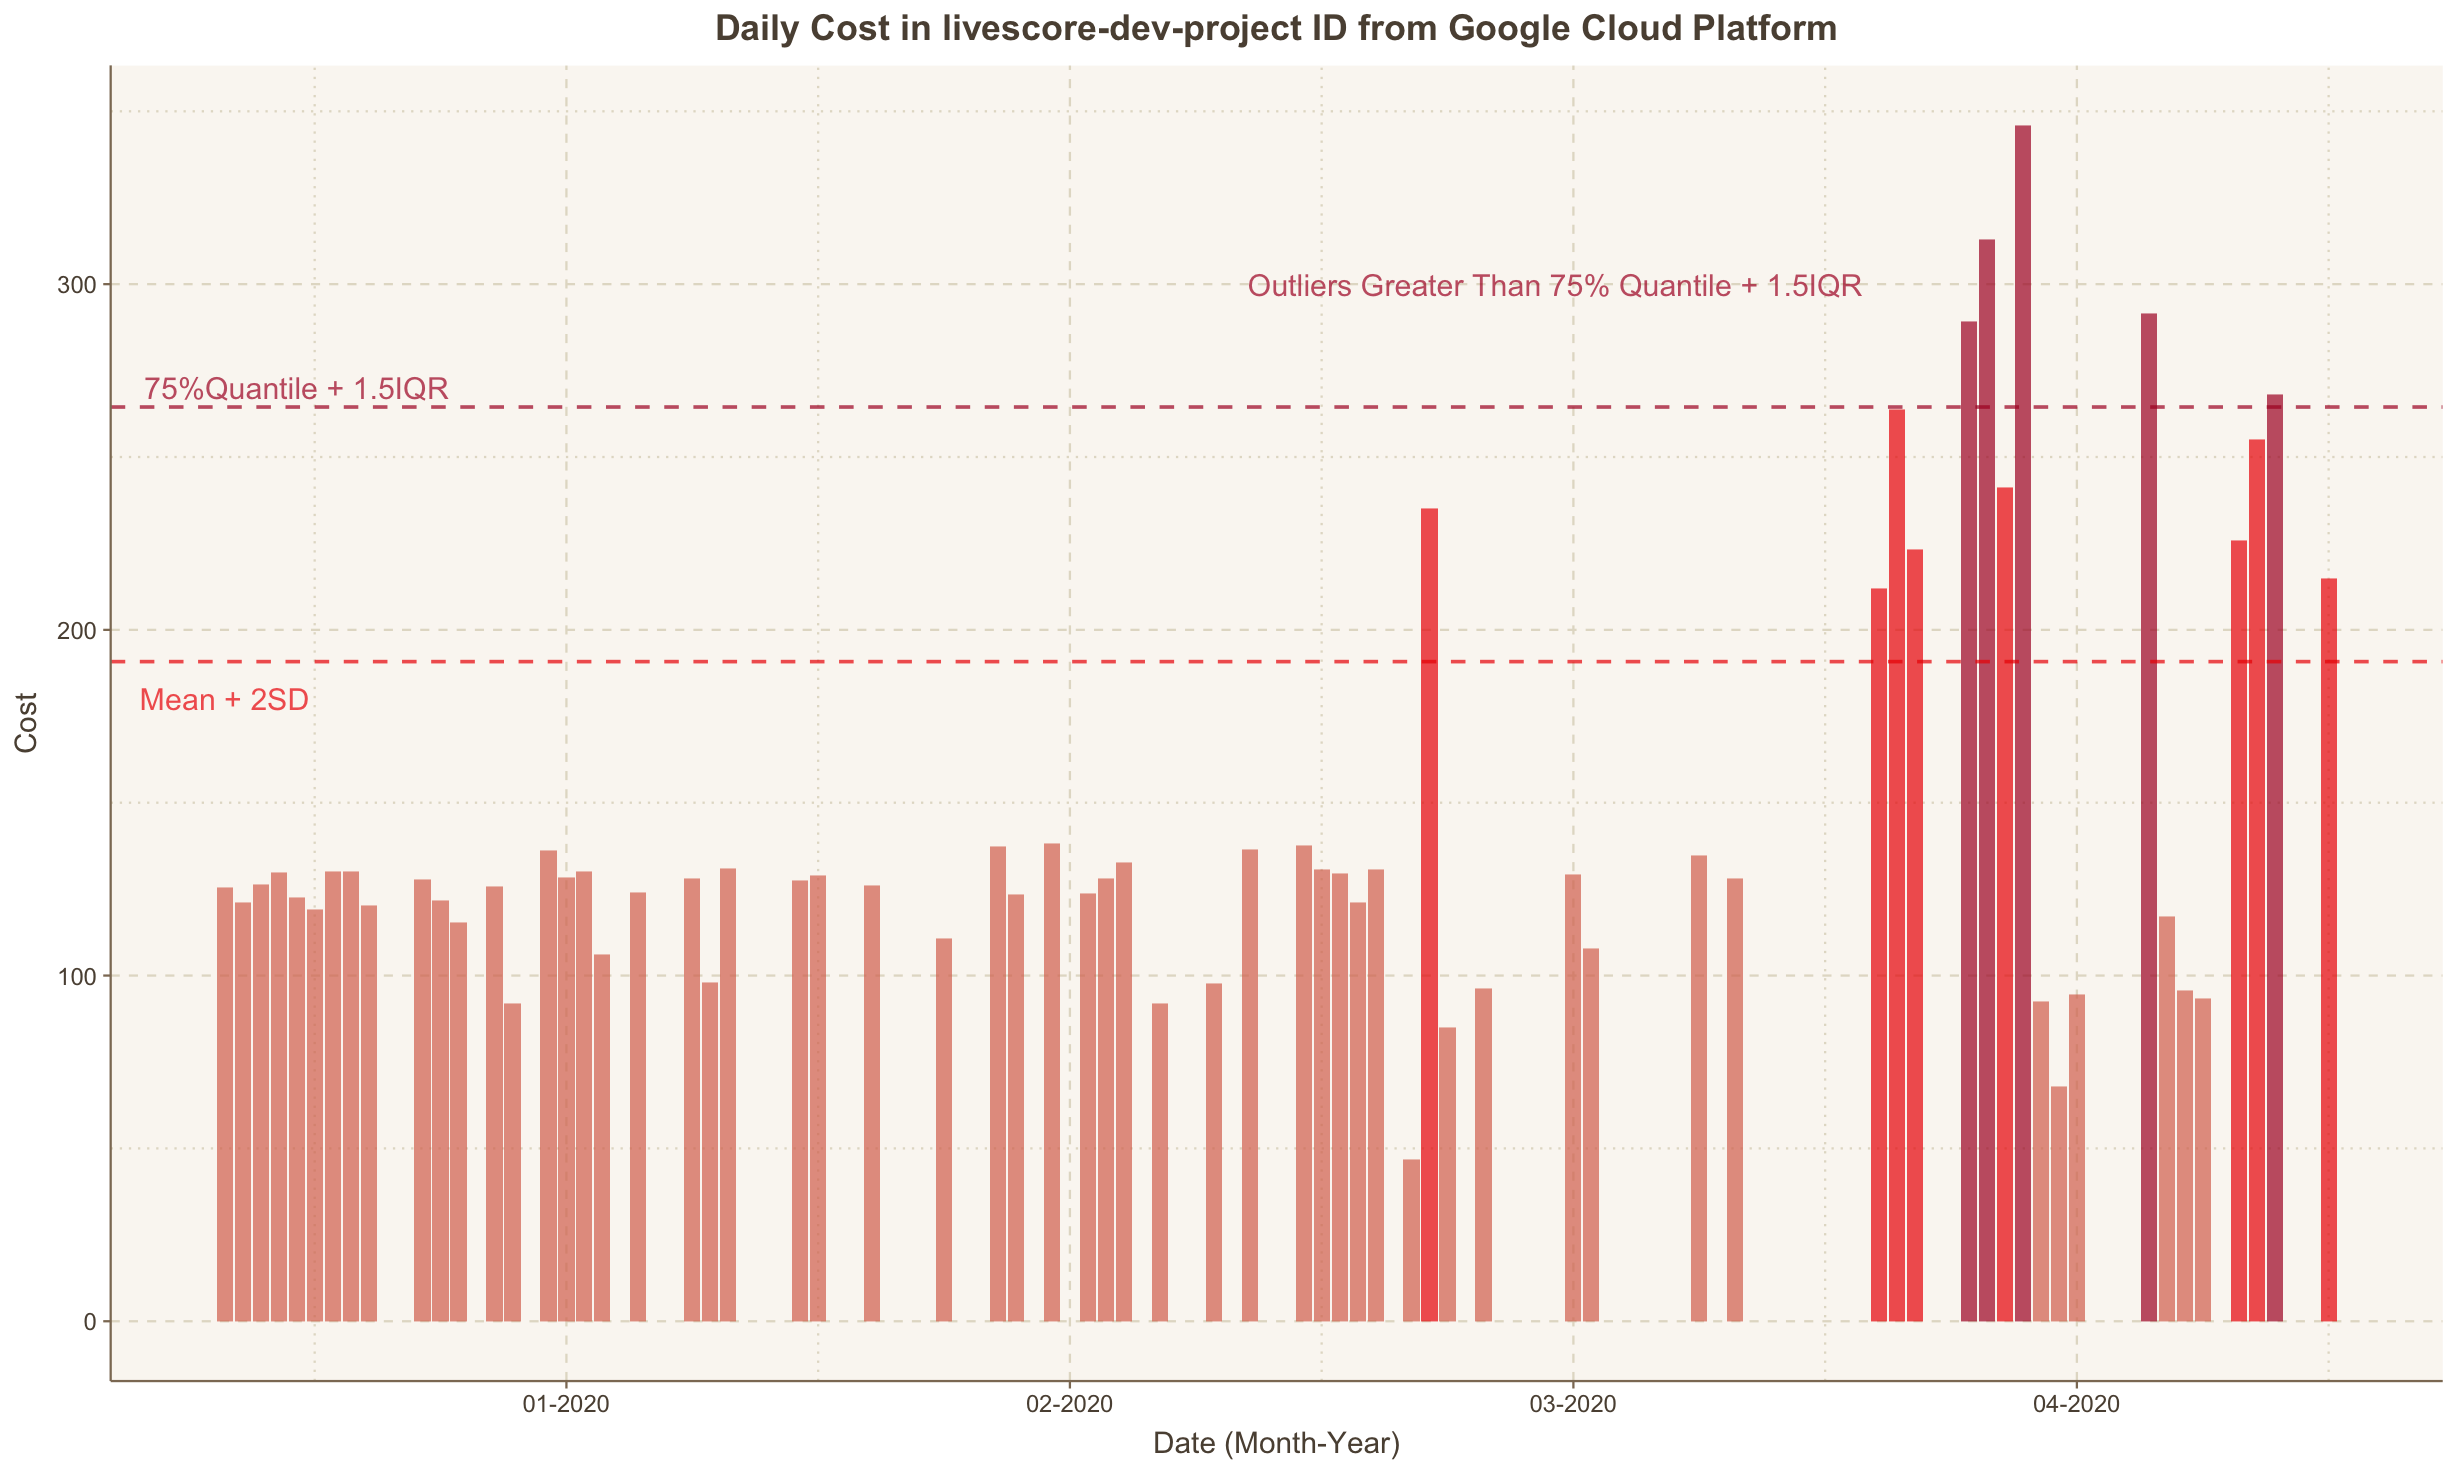

In [11]:
img = Image.open("image/livescore_dev.png")
img

<h2> Cost Baseline Model </h2>

This part, based on the statistics summary displayed before, assumes that daily cost in main projects and products follow the <b>Generalized Extreme Value Distribution</b> given the enough historical cost data. Note that this part only demonstrates the distributions fitted to daily cost in main project as it experiences the same procedures for main product.

Firstly, we provide several histogram of daily cost in five main projects along with the density plot of Generalized Extreme Value distribution to support our assumption why we apply Generalized Extreme Value distribution.

Secondly, parameters for corresponding daily cost distribution is estimated by linear moments. Probability density plot and cumulative probability plot are provided as a proof for goodness-of-fit.

Thirdly, Monte Carlo simulation is applied to estimate the probability that daily cost on today for a specific project will be greater than threshold <b>(mean + 2SD)</b> decided by recent ten-day historical cost data in corresponding project. The number of draw for each project are decided by the average number of cost records in recent ten days. This probability finally becomes our baseline probability to monitor our daily cost. 

In [174]:
from lmoments3 import distr
from scipy.stats import genextreme, gamma, genpareto, gumbel_r
from scipy import stats as stats

In [4]:
cost_project = pd.read_csv("data/cost_project.csv")
print(cost_project.shape)

cost_project = cost_project.loc[
    cost_project.cost >= 0
]
print(cost_project.shape)

(8358, 3)
(8342, 3)


/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/tensorflow-venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2552: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)
/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/tensorflow-venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2552: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


<Figure size 864x432 with 0 Axes>

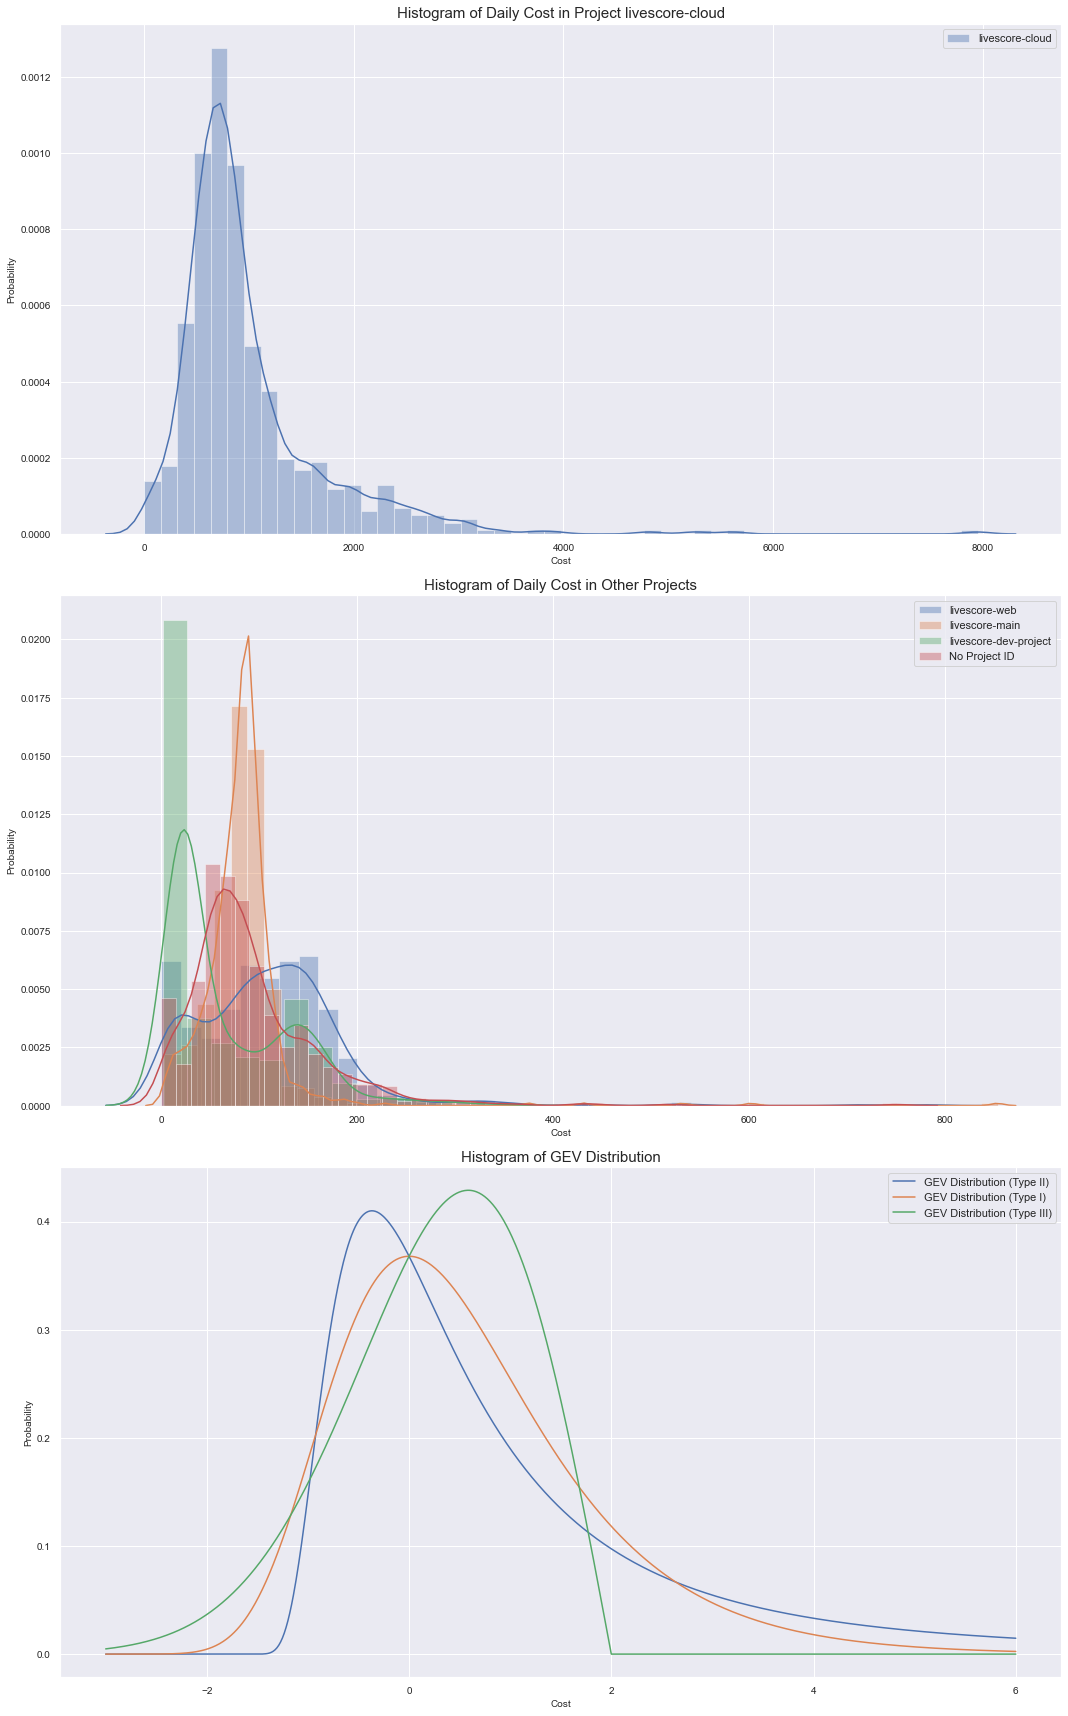

In [367]:
fig_size = [15, 24]
fig = plt.figure()
fig, axes = plt.subplots(3, 1, figsize = fig_size)
    
plot1 = sns.distplot(
    cost_project.loc[cost_project.project == "livescore-cloud"].cost, label = "livescore-cloud", ax = axes[0]
)
plot2 = sns.distplot(
    cost_project.loc[cost_project.project == "livescore-web"].cost, label = "livescore-web", ax = axes[1]
)
plot2 = sns.distplot(
    cost_project.loc[cost_project.project == "livescore-main"].cost, label = "livescore-main", ax = axes[1]
)
plot2 = sns.distplot(
    cost_project.loc[cost_project.project == "livescore-dev-project"].cost, 
    label = "livescore-dev-project", ax = axes[1]
)
plot2 = sns.distplot(
    cost_project.loc[cost_project.project.isna()].cost, 
    label = "No Project ID", ax = axes[1]
)

x = np.linspace(-3, 6, 1000)
y1 = genextreme.pdf(x, -0.5, 0, 1)
y2 = genextreme.pdf(x, 0, 0, 1)
y3 = genextreme.pdf(x, 0.5, 0, 1)

plot3 = sns.lineplot(
    x = x,
    y = y1,
    label = "GEV Distribution (Type II)",
    ax = axes[2]
)
plot3 = sns.lineplot(
    x = x,
    y = y2,
    label = "GEV Distribution (Type I)",
    ax = axes[2]
)
plot3 = sns.lineplot(
    x = x,
    y = y3,
    label = "GEV Distribution (Type III)",
    ax = axes[2]
)

axes[0].set_title("Histogram of Daily Cost in Project livescore-cloud", fontsize = 15)
axes[0].set_ylabel("Probability", fontsize = 10)
axes[0].tick_params(labelsize = 10)
axes[0].set_xlabel("Cost", fontsize = 10)
axes[0].legend()
axes[1].set_title("Histogram of Daily Cost in Other Projects", fontsize = 15)
axes[1].set_ylabel("Probability", fontsize = 10)
axes[1].tick_params(labelsize = 10)
axes[1].set_xlabel("Cost", fontsize = 10)
axes[1].legend()
axes[2].set_title("Histogram of GEV Distribution", fontsize = 15)
axes[2].set_ylabel("Probability", fontsize = 10)
axes[2].tick_params(labelsize = 10)
axes[2].set_xlabel("Cost", fontsize = 10)
axes[2].legend()
fig.tight_layout()

In [266]:
def ecdf(data):
    
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 1) / n
    return(x, y)

def fit_gev(data):
    
    from lmoments3 import distr
    
    parameters = distr.gev.lmom_fit(data)
    return parameters

def plot_fitted(data, parameters):
    
    from scipy.stats import genextreme
    
    fig_size = [15, 16]
    fig = plt.figure()
    fig, axes = plt.subplots(2, 1, sharex = True, figsize = fig_size)
    
    pdf_plot = sns.kdeplot(data, label = "Empirical Cost", shade = True, ax = axes[0])
    pdf_plot = sns.lineplot(
        x = data, y = genextreme.pdf(np.sort(data), parameters["c"], parameters["loc"], parameters["scale"]),
        label = "Estimated Cost", ax = axes[0]
    )
    cdf_plot = sns.lineplot(
        x = ecdf(data)[0], y = ecdf(data)[1], label = "Empirical Cost", ax = axes[1]
    )
    cdf_plot = sns.lineplot(
        x = data, y = genextreme.cdf(np.sort(data), parameters["c"], parameters["loc"], parameters["scale"]),
        label = "Estimated Cost", ax = axes[1]
    )
    axes[0].set_title("Probability Density Plot of Empirical and Estimated Cost", fontsize = 15)
    axes[0].set_ylabel("Probability", fontsize = 10)
    axes[0].tick_params(labelsize = 10)
    axes[1].set_title("Cumulative Probability Plot of Empirical and Estimated Cost", fontsize = 15)
    axes[1].set_ylabel("Cumulative Probability", fontsize = 10)
    axes[1].tick_params(labelsize = 10)
    axes[1].set_xlabel("Cost", fontsize = 10)
    fig.tight_layout()

<Figure size 864x432 with 0 Axes>

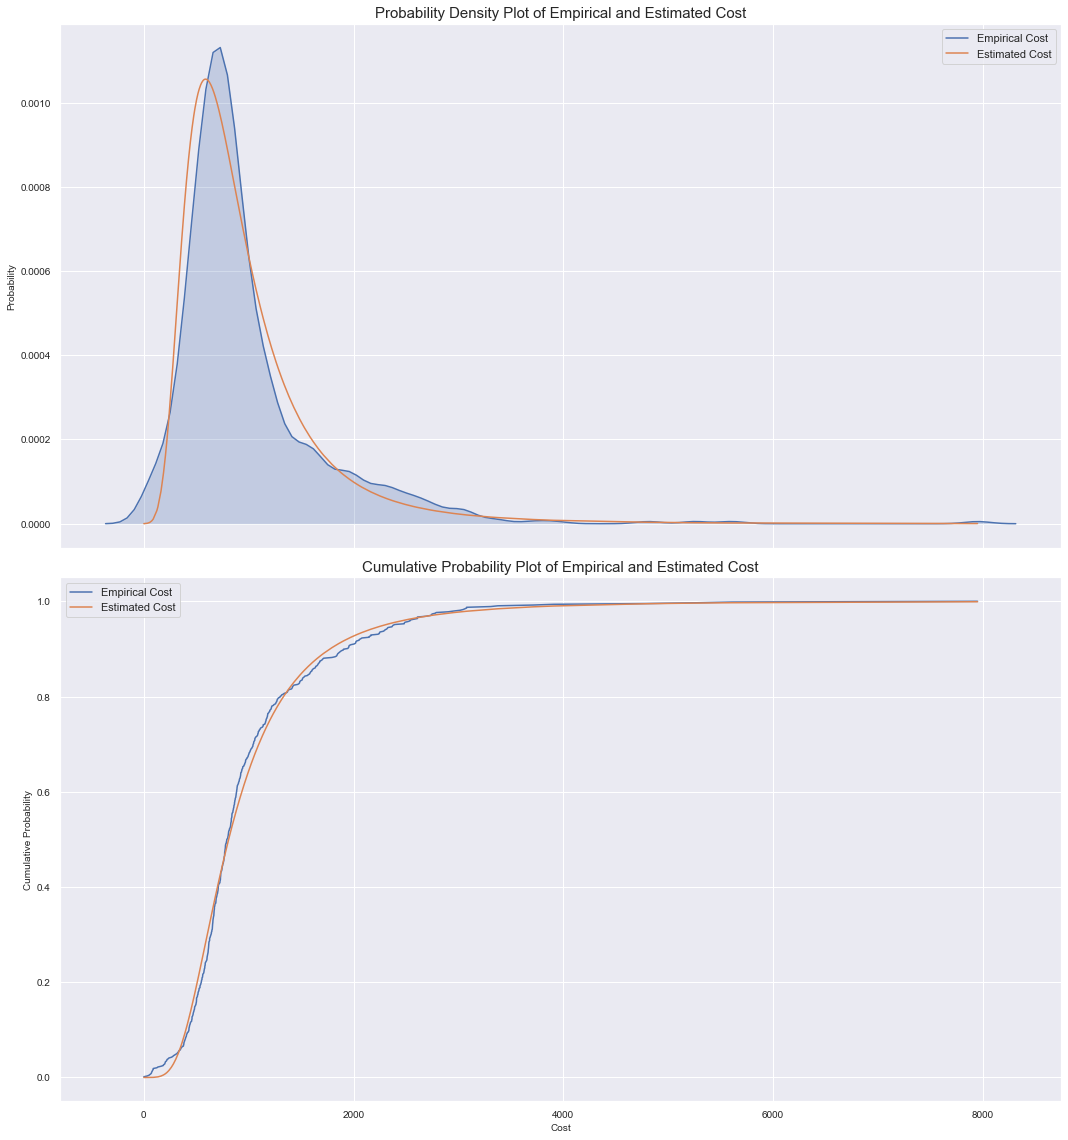

In [267]:
cost_cloud = cost_project.loc[cost_project.project == "livescore-cloud"].cost
params_cloud = fit_gev(cost_cloud)
plot_fitted(cost_cloud, params_cloud)

<Figure size 864x432 with 0 Axes>

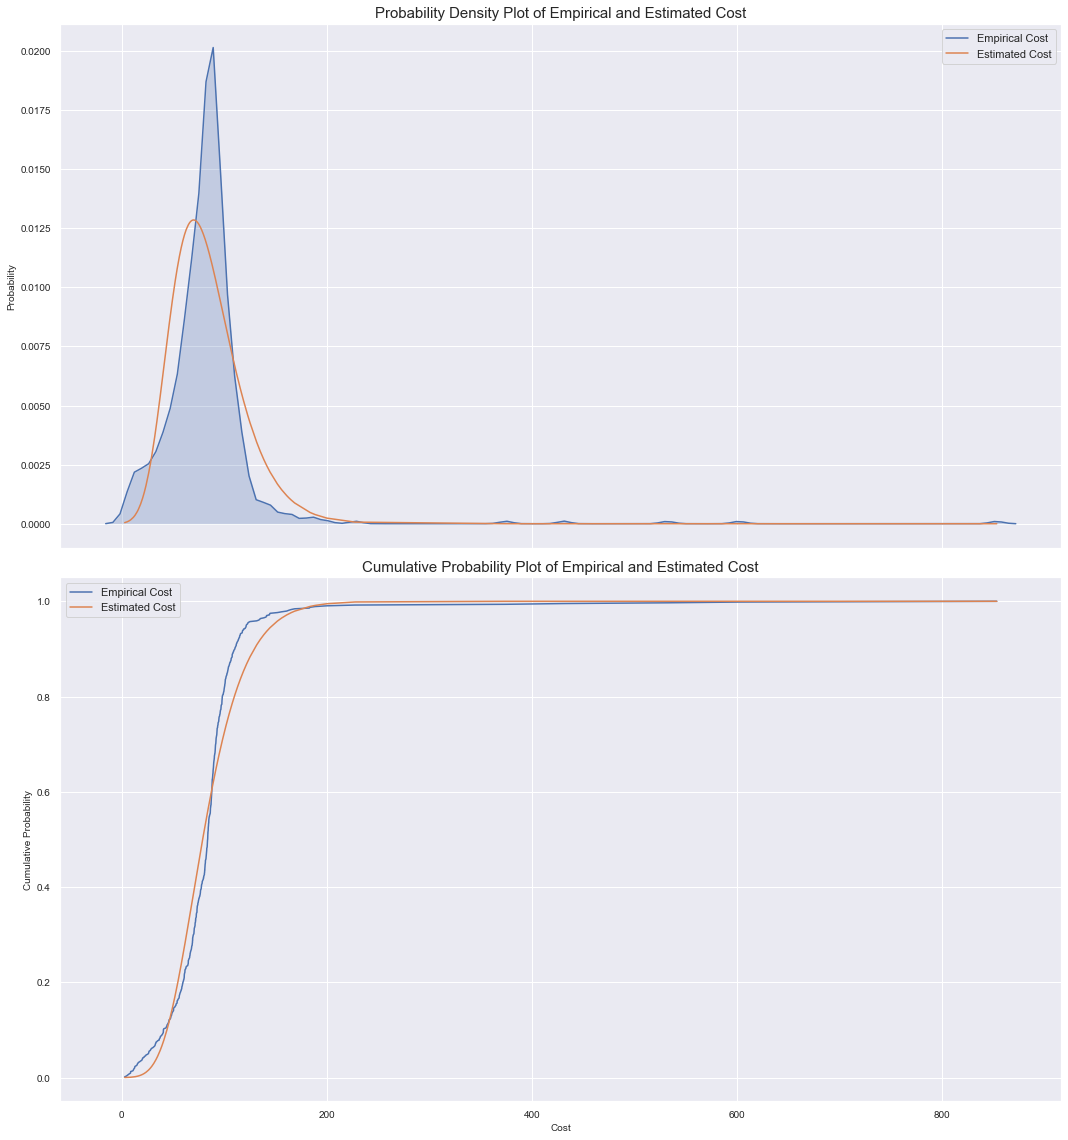

In [274]:
cost_main = cost_project.loc[cost_project.project == "livescore-main"].cost
params_main = fit_gev(cost_main)
plot_fitted(cost_main, params_main)

<Figure size 864x432 with 0 Axes>

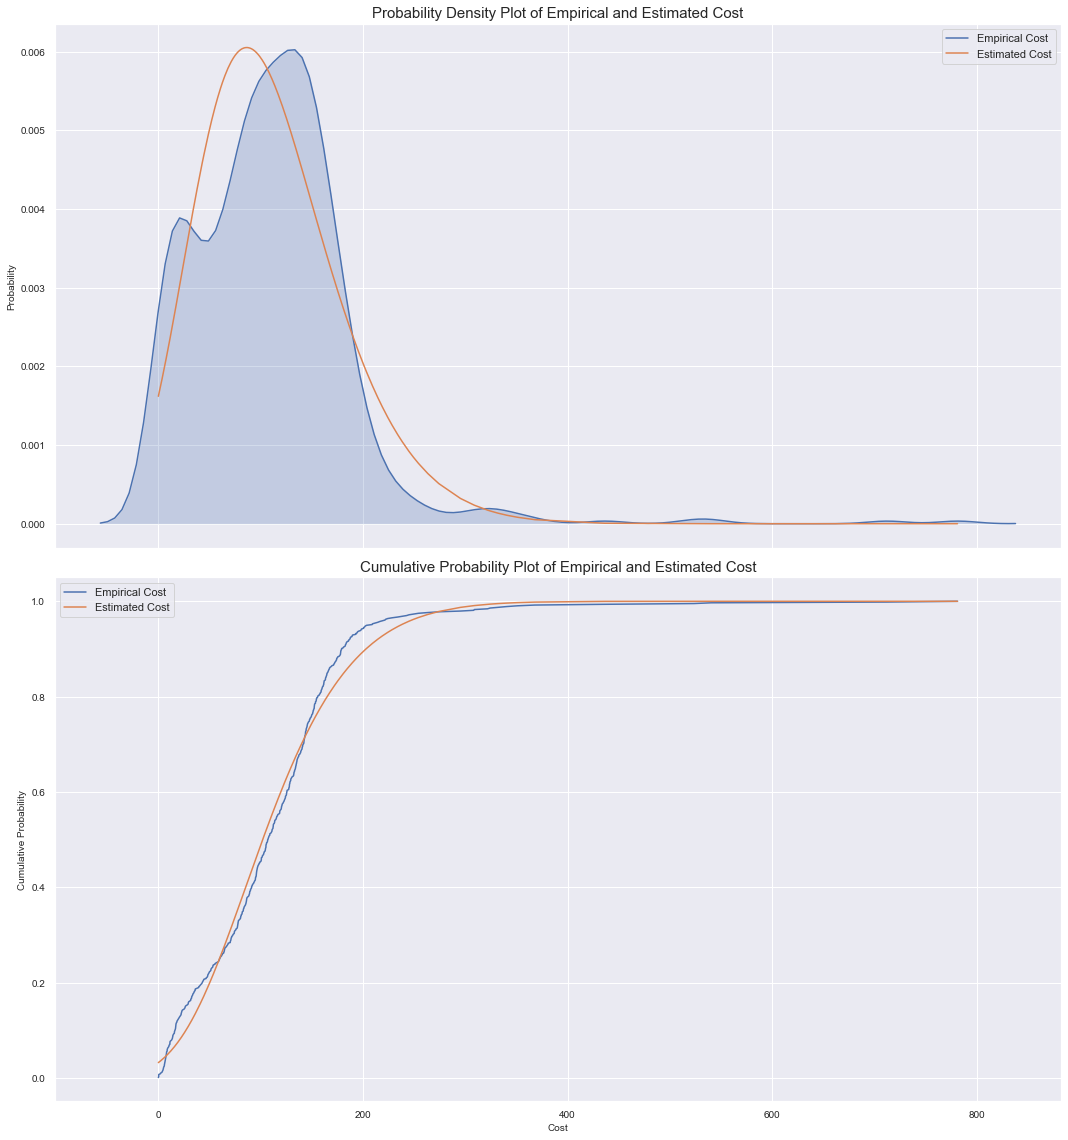

In [275]:
cost_web = cost_project.loc[cost_project.project == "livescore-web"].cost
params_web = fit_gev(cost_web)
plot_fitted(cost_web, params_web)

<Figure size 864x432 with 0 Axes>

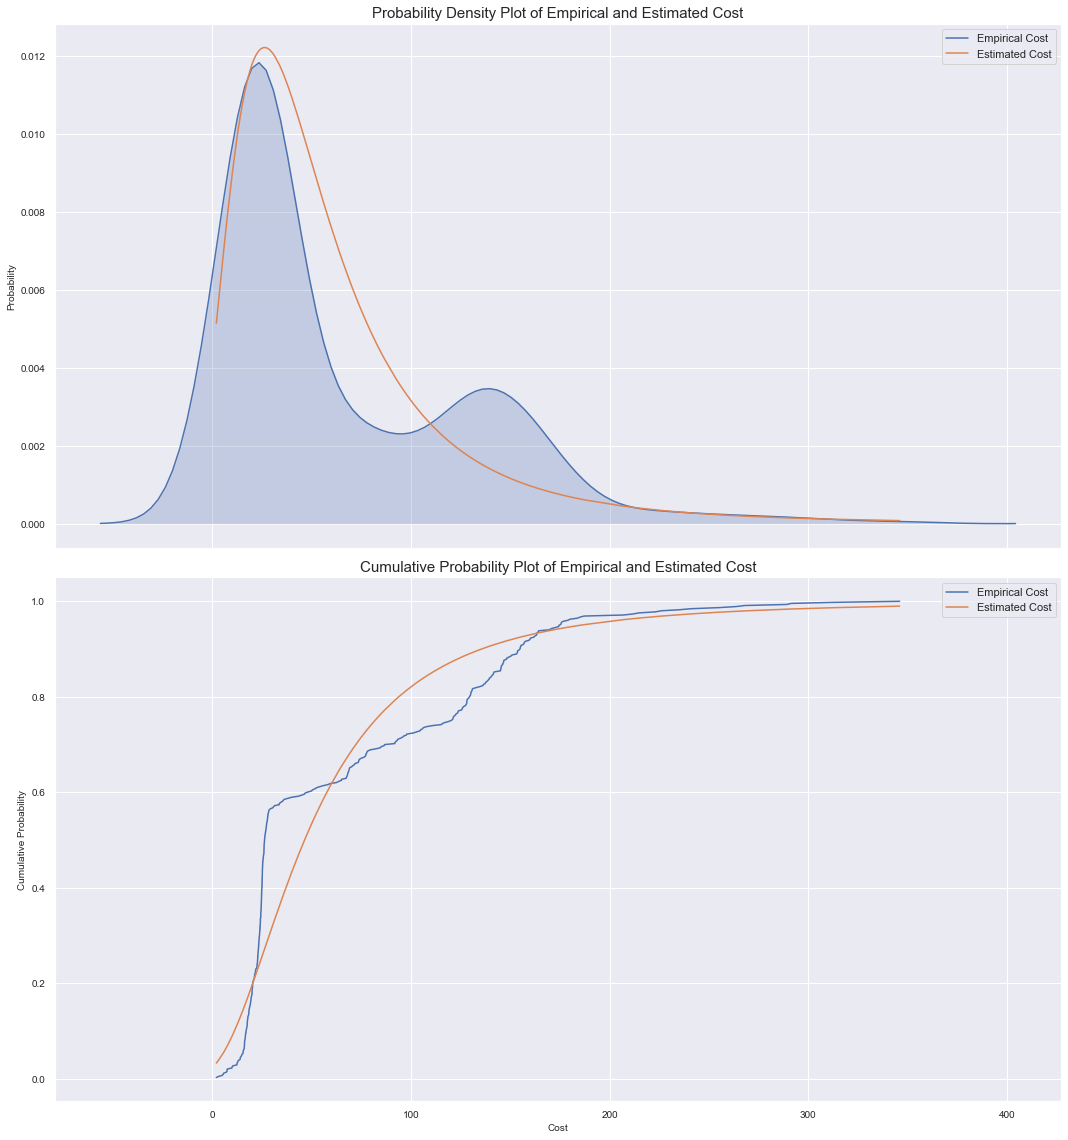

In [276]:
cost_dev = cost_project.loc[cost_project.project == "livescore-dev-project"].cost
params_dev = fit_gev(cost_dev)
plot_fitted(cost_dev, params_dev)

<Figure size 864x432 with 0 Axes>

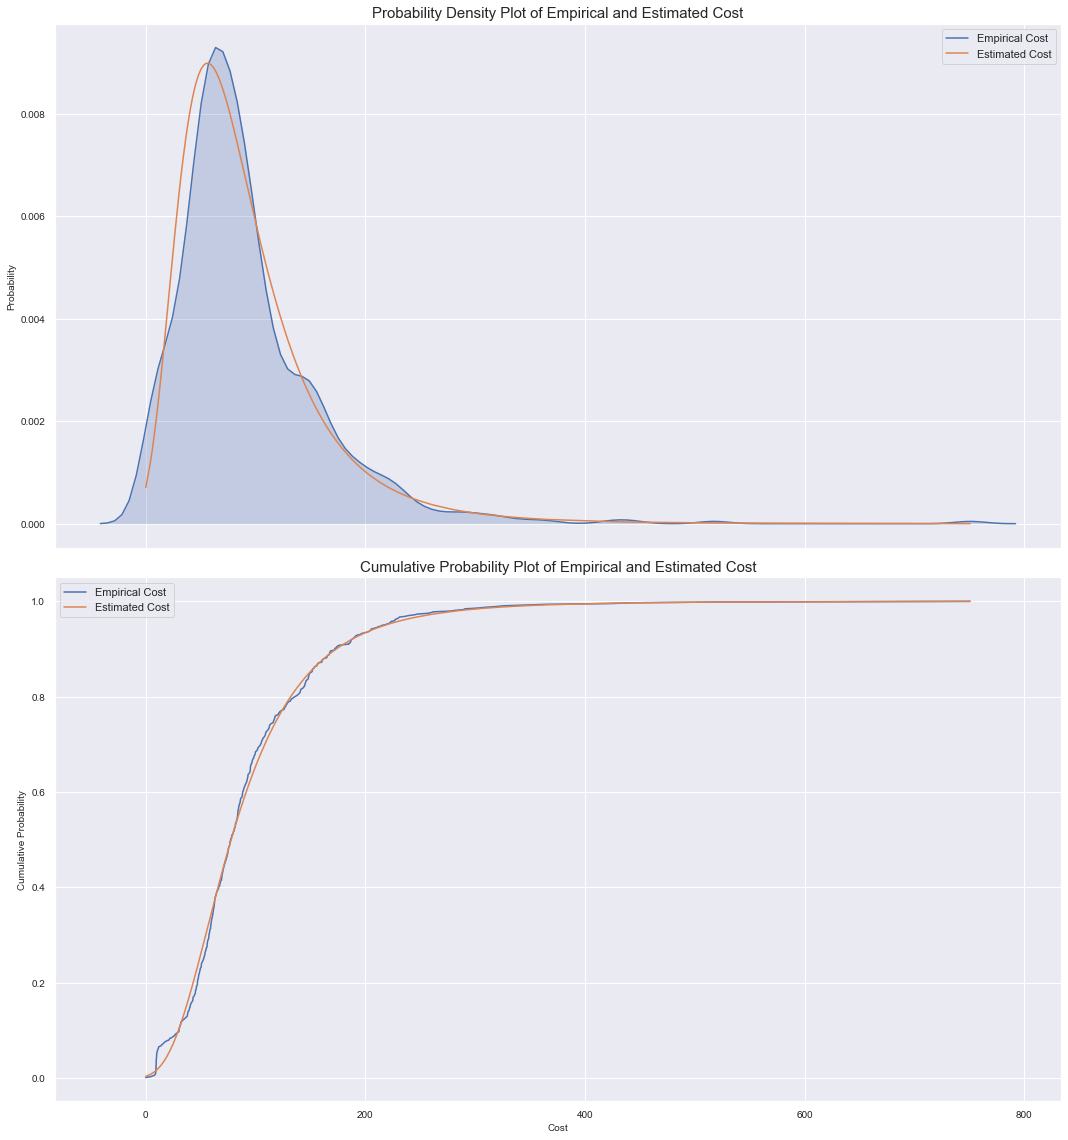

In [277]:
cost_none = cost_project.loc[cost_project.project.isna()].cost
params_none = fit_gev(cost_none)
plot_fitted(cost_none, params_none)

Here we also provide another statistical test - <b>Kolmogorov–Smirnov test</b> to evaluate our goodness-of-fit for each distribution. This test is frequently used to test whether univariate empirical and estimated distribution are from the same distribution. P-value greater than 5% proves that it can not reject the hypothesis that these two distributions are the same. 

The result is similar to cumulative probability plot in the above where the larger discrepancy between empirical and estimated distribution is, the higher probability that two distribution are different is.

In [173]:
r = genextreme.rvs(params["c"], params["loc"], params["scale"], size = 1000)
stats.ks_2samp(cost_project_livescore_cloud.cost, r)

Ks_2sampResult(statistic=0.04479874213836478, pvalue=0.4012304721898601)

This baseline table is queried from BigQuery. The SQL is shown as follows:

<pre>
WITH cost_table AS (
SELECT 
  DATE(export_time) AS date,
  IFNULL(project.id, "None") AS project,
  ROUND(SUM(Cost), 2) AS cost,
  COUNT(IFNULL(project.id, "None")) AS noCost
FROM
  `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
WHERE 
  DATE(export_time) >= DATE_SUB(CURRENT_DATE, INTERVAL 10 DAY) AND DATE(export_time) < CURRENT_DATE
GROUP BY 
  date, project
),

cost_summary AS (
SELECT
  project,
  ROUND(AVG(cost), 2) as avgCost,
  ROUND(STDDEV(cost), 2) AS sdCost,
  CAST(AVG(noCost) AS INT64) AS avgNoCost
FROM 
  cost_table
GROUP BY 
  project
),

cost_today AS(
SELECT
  DATE(export_time) AS date,
  IFNULL(project.id, "None") AS project,
  ROUND(SUM(Cost), 2) AS cost
FROM
  `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
WHERE 
  DATE(export_time) = CURRENT_DATE
GROUP BY 
  date, project
)

SELECT
  date,
  project,
  cost,
  ROUND(cost_summary.avgCost + 2 * cost_summary.sdCost, 2) AS threshold,
  cost_summary.avgCost AS mean,
  cost_summary.sdCost AS sd,
  cost_summary.avgNoCost AS avgNo
FROM 
  cost_today 
LEFT JOIN cost_summary
  using (project)
ORDER BY 
  project ASC
</pre>

Historical cost data in recent ten days are used to estimate the threshold and the number of draw for Monte Carlo simulation.

In [280]:
cost_baseline.loc[
    cost_baseline.project.isin(
        ["None", "livescore-cloud", "livescore-main", "livescore-web", "livescore-dev-project"]
    )
]

,date,project,cost,threshold,mean,sd,avgNo
0,2020-04-30,None,-433.03,10.07,9.47,0.30,108.0
9,2020-04-30,livescore-cloud,466.45,937.00,845.26,45.87,28102.0
11,2020-04-30,livescore-dev-project,189.20,327.56,210.72,58.42,8029.1
14,2020-04-30,livescore-main,43.41,106.74,90.22,8.26,114.9
20,2020-04-30,livescore-web,35.58,163.30,119.46,21.92,1945.3


In [320]:
def outlier_probability(name, parameters, baseline_df):
    
    from scipy.stats import genextreme
    
    try:
        threshold = baseline_df.loc[baseline_df.project == name].threshold
        number = int(baseline_df.loc[baseline_df.project == name].avgNo)
    except:
        threshold = baseline_df.loc[baseline_df.product == name].threshold
        number = int(baseline_df.loc[baseline_df.project == name].avgNo)
    
    cost_rnd = genextreme.rvs(**parameters, size = number)
    prob_rnd = sum(cost > threshold for cost in cost_rnd) / number * 100
    print("\n")
    print(name)
    print(
        "Monte Carlo Simulation Probability of Daily Cost in", name,
        "Greater Than Threshold: %1.2f" %(prob_rnd), "%"
    )
    print(
        "Density Probability of Daily Cost in", name, "Greater Than Threshold: %1.2f" 
        %((1-genextreme.cdf(threshold, **parameters))*100), "%"
    )
    return cost_rnd, prob_rnd

Although we provide two different kinds of probability estimation <b>(Monte Carlo and density estimation)</b>, we suggest using probability estimated by <b>Monte Carlo simulation</b> as it also takes the number of cost records every day into account. However, density estimation is calculated given the relative large number of sample data.

In [322]:
cost_dict = {}
prob_dict = {}
project_list = ["None", "livescore-cloud", "livescore-dev-project", "livescore-main", "livescore-web"]
params_list = [params_none, params_cloud, params_dev, params_main, params_web]
for project, params in zip(project_list, params_list):
    cost_dict[project], prob_dict[project] = outlier_probability(project, params, cost_baseline)



None
Monte Carlo Simulation Probability of Daily Cost in None Greater Than Threshold: 97.22 %
Density Probability of Daily Cost in None Greater Than Threshold: 98.24 %


livescore-cloud
Monte Carlo Simulation Probability of Daily Cost in livescore-cloud Greater Than Threshold: 39.94 %
Density Probability of Daily Cost in livescore-cloud Greater Than Threshold: 39.81 %


livescore-dev-project
Monte Carlo Simulation Probability of Daily Cost in livescore-dev-project Greater Than Threshold: 1.18 %
Density Probability of Daily Cost in livescore-dev-project Greater Than Threshold: 1.18 %


livescore-main
Monte Carlo Simulation Probability of Daily Cost in livescore-main Greater Than Threshold: 26.32 %
Density Probability of Daily Cost in livescore-main Greater Than Threshold: 22.10 %


livescore-web
Monte Carlo Simulation Probability of Daily Cost in livescore-web Greater Than Threshold: 20.62 %
Density Probability of Daily Cost in livescore-web Greater Than Threshold: 20.58 %


The result in the above indicates that we should keep an eye on None Project ID as it has a really high probability over the threshold.

The probability is estimated given recent data rather than the whole data. If a series of cost for a specific project keeping in a relative low level recently which experienced a stage of high-cost level before are more likely to have a high probability over the threshold because the distribution is estimated by the <b>whole data</b> while the threshold is calculated by the <b>recent data</b>, vice versa.

<h2> Cost Prediction </h2>

In [303]:
import tensorflow as tf
print(tf.__version__)
import tqdm

import tensorflow.python.keras.backend as K

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *

2.1.0


Considering the size of data, our label (daily cost) and our features (daily cost as well and also include the number of cost), we implement <b>a clever LSTM Autoencoder</b> for new features creation. Then we combine daily cost with the features generated from LSTM Autoencoder to train a LSTM neural network. Hence there are two steps for this model:

<ol>
    <li> LSTM Autoencoder
    <li> LSTM Forecaster
</ol>

We aim to predict the daily cost for different projects and products. Considering the similarity pattern for daily cost in both projects and products. We display a machine learning model to predict the daily cost in ID-Null. We will use <b>Long-Short-Term-Memory Neural Network (LSTM)</b> to predict the future cost.

Considering the size of data, our label (daily cost) and our features (daily cost as well and also include the number of cost), we implement <b>a clever LSTM Autoencoder</b> for new features creation. Then we combine daily cost with the features generated from LSTM Autoencoder to train a LSTM neural network. Hence there are two steps for this model:

<ol>
    <li> LSTM encoder
    <li> LSTM Forecaster
</ol>

In [472]:
# Global Paramters

feature_names = ["cost", "noCost"]
label_name = "cost"
sequence_length = 7
train_split = 595
dropout = 0.3
buffer_size = 1000
batch_size = 5
epochs_encoder = 100
evaluation_interval = 200
encode_wide = [128]
decode_wide = [32]
epochs_forecaster = 50
forecaster_wide = [400, 200]
dense_size = 200

In [600]:
def read_data_bq(filepath):
    
    # Read data from BigQuery
    with open(filepath) as f:
        sql = f.read()
    data = bigquery_client.query(sql).to_dataframe()
    
    return data

def get_sequence(data, sequence_length = 7):
    
    sequence = []
    num_elements = data.shape[0]

    for start, end in zip(range(0, num_elements-sequence_length), range(sequence_length, num_elements)):
        sequence.append(data[start:end])
    sequence = np.asarray(sequence).reshape((num_elements-sequence_length, sequence_length, 1))
    return sequence

def get_label(data, sequence_length = 7):

    num_elements = data.shape[0]
    label = np.asarray(data[sequence_length:num_elements])
    label = label.reshape((data[sequence_length:num_elements].shape[0], 1))

    return label

In [320]:
cost = cost_project_null.drop(["date", "project"], axis = 1).values
# scaler = MinMaxScaler()
# cost_transform = scaler.fit(cost[:train_split,:]).transform(cost)
train_split = 595

### Try a scaler but performance is not very well
# cost_train_min = cost_train[:train_split].min()
# cost_train_max = cost_train[:train_split].max()
# cost_transform = (cost - cost_train_min) / (cost_train_max - cost_train_min)
# cost_transform = 2 * ((cost - cost_train_min) / (cost_train_max - cost_train_min)) - 1
# cost_train, cost_test = split_dataset(cost_transform, 602)

# X_train, X_test = get_sequence(cost_transform[:train_split], 0), get_sequence(cost_transform[train_split:], 0)
# y_train, y_test = get_label(cost_transform[:train_split], 0), get_label(cost_transform[train_split:], 0)
# F_train, F_test = get_features(cost_transform[:train_split], 1), get_features(cost_transform[train_split:], 1)

X_train, X_test = get_sequence(cost[:train_split]), get_sequence(cost[train_split:])
y_train, y_test = get_label(cost[:train_split], 0), get_label(cost[train_split:], 0)
# F_train, F_test = get_features(cost[:train_split], 1), get_features(cost[train_split:], 1)

# X_train, y_train = generate_inputs_outputs(cost_train, 7, 1)
# X_test, y_test = generate_inputs_outputs(cost_test, 7, 1)

In [591]:
def build_lstm_autoencoder(X, dropout, encode_wide, decode_wide):
    
    # Neuron Architecture
    # Input Layer
    input_layer = Input(shape = (X.shape[1], X.shape[2]))
    # Encoder Layer
    for deep, wide in enumerate(encode_wide):
        if deep == 0:
            encoded_layer = LSTM(wide, return_sequences = True)(input_layer, training = True)
            # encoded_layer = BatchNormalization()(encoded_layer, training = True)
            encoded_layer = Dropout(dropout)(encoded_layer, training = True)       
        else:
            encoded_layer = LSTM(wide, return_sequences = True)(encoded_layer, training = True)
            # encoded_layer = BatchNormalization()(encoded_layer, training = True)
            encoded_layer = Dropout(dropout)(encoded_layer, training = True)
    # Decoder Layer
    for deep, wide in enumerate(decode_wide):
        if deep == 0:
            decoded_layer = LSTM(wide, return_sequences = True)(encoded_layer, training = True)
            # decoded_layer = BatchNormalization()(decoded_layer, training = True)
            decoded_layer = Dropout(dropout)(decoded_layer, training = True)
        else:
            decoded_layer = LSTM(wide, return_sequences = True)(decoded_layer, training = True)
            # decoded_layer = BatchNormalization()(decoded_layer, training = True)
            decoded_layer = Dropout(dropout)(decoded_layer, training = True)
    # Output Layer
    output_layer = TimeDistributed(Dense(X.shape[2]))(decoded_layer)
    
    lstm_encoder = Model(input_layer, encoded_layer)
    lstm_autoencoder = Model(input_layer, output_layer)
    lstm_autoencoder.compile(optimizer = RMSprop(), loss = "mean_squared_error")
    
    return lstm_encoder, lstm_autoencoder

lstm_encoder, lstm_autoencoder = build_lstm_autoencoder(
    X_train, dropout = 0.3, encode_deep = 1, encode_wide = [128], decode_deep = 1, decode_wide = [32]
)
lstm_autoencoder.summary()
lstm_autoencoder.compile(optimizer = RMSprop(), loss = "mean_squared_error")
history_lstm_autoencoder = lstm_autoencoder.fit(
    X_train, X_train, epochs = 100, batch_size = 5, verbose = 2, shuffle = True, 
    validation_data = (X_test, X_test)
)

Model: "model_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        [(None, 7, 2)]            0         
_________________________________________________________________
lstm_174 (LSTM)              (None, 7, 128)            67072     
_________________________________________________________________
dropout_167 (Dropout)        (None, 7, 128)            0         
_________________________________________________________________
lstm_175 (LSTM)              (None, 7, 32)             20608     
_________________________________________________________________
dropout_168 (Dropout)        (None, 7, 32)             0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 7, 2)              66        
Total params: 87,746
Trainable params: 87,746
Non-trainable params: 0
_____________________________________________________

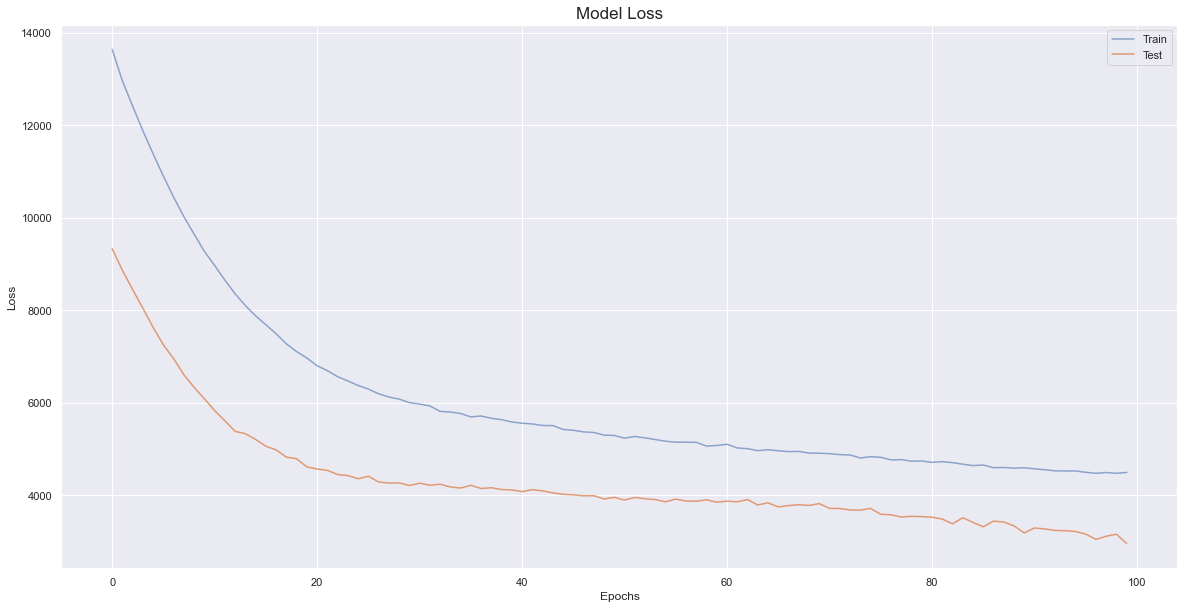

In [409]:
def loss_plot(history):
    
    plt.figure(figsize = (20, 10))
    plt.plot(history.history["loss"], alpha = 0.6)
    plt.plot(history.history["val_loss"], alpha = 0.8)
    plt.title("Model Loss", fontsize = 17)
    plt.xlabel("Epochs", fontsize = 12)
    plt.ylabel("Loss", fontsize = 12)
    plt.legend(["Train", "Test"], loc = "upper right")
    plt.show()
    
loss_plot(history_lstm_autoencoder)

In [592]:
def sequence_extraction(encoder, X, F, sequence_length, mode, F_included = False):
    
    X_encoded = encoder.predict(X)
    X_ensemble = np.asarray(
        [tf.math.reduce_mean(X_encoded[_1, _2, :]) for _1 in range(X_encoded.shape[0]) for _2 in range(sequence_length)]
    ).reshape(X_encoded.shape[0], X_encoded.shape[1], 1)
    
    # Encoder will generate multiple sequences from original one.
    # We can directly use the raw sequences generated from encoder Or use the ensembled sequence (averaging).
    # We can also consider whether includes fixtures in the forecaster.
    if mode == "raw":
        if F_included:
            X_extract = np.concatenate([X_encoded, X, F], axis = 2)
        else:
            X_extract = np.concatenate([X_encoded, X], axis = 2)     
    elif mode == "ensemble":
        if F_included:
            X_extract = np.concatenate([X_ensemble, X, F], axis = 2)
        else:
            X_extract = np.concatenate([X_ensemble, X], axis = 2)       
    else:
        pass
    
    return X_extract

X_extract = sequence_extraction(lstm_encoder, X_train, F_train, sequence_length = 7, mode = "raw")
X_test_extract = sequence_extraction(lstm_encoder, X_test, F_test, sequence_length = 7, mode = "raw")

In [593]:
def rmse(y, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y))) 

def build_lstm_forecaster(X, dropout, forecaster_wide, dense_size):
    
    ### Neuron Architecture
    # Input Layer
    input_lstm = Input(shape = (X.shape[1], X.shape[2]))
    # LSTM Layer
    if len(forecaster_wide) == 1:
        lstm = LSTM(forecaster_wide[0], return_sequences = False)(input_lstm, training = True)
        # lstm = BatchNormalization()(lstm, training = True)
        lstm = Dropout(dropout)(lstm, training = True)
    else:
        for deep, wide in enumerate(forecaster_wide):
            if deep == 0:
                lstm = LSTM(wide, return_sequences = True)(input_lstm, training = True)
                # lstm = BatchNormalization()(lstm, training = True)
                lstm = Dropout(dropout)(lstm, training = True)
            elif deep == len(forecaster_wide) - 1:
                lstm = LSTM(wide, return_sequences = False)(lstm, training = True)
                # lstm = BatchNormalization()(lstm, training = True)
                lstm = Dropout(dropout)(lstm, training = True)
            else:
                lstm = LSTM(wide, return_sequences = True)(lstm, training = True)
                # lstm = BatchNormalization()(lstm, training = True)
                lstm = Dropout(dropout)(lstm, training = True)
    # Output Layer
    dense = Dense(dense_size)(lstm)
    output_lstm = Dense(1)(dense)
    
    forecaster = Model(input_lstm, output_lstm)
    forecaster.compile(optimizer = RMSprop(), loss = "mean_squared_error", metrics = [rmse, "mse"])
    
    return forecaster

lstm_forecaster = build_lstm_forecaster(
    X_extract, dropout = 0.3, lstm_deep = 2, lstm_wide = [400, 200], dense_size = 200
)
lstm_forecaster.summary()
history_forecaster = lstm_forecaster.fit(
    X_extract, y_train, epochs = 50, batch_size = 5, verbose = 2, shuffle = True,
    validation_data = (X_test_extract, y_test)
)

Model: "model_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        [(None, 7, 130)]          0         
_________________________________________________________________
lstm_176 (LSTM)              (None, 7, 400)            849600    
_________________________________________________________________
dropout_169 (Dropout)        (None, 7, 400)            0         
_________________________________________________________________
lstm_177 (LSTM)              (None, 200)               480800    
_________________________________________________________________
dropout_170 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_136 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 20

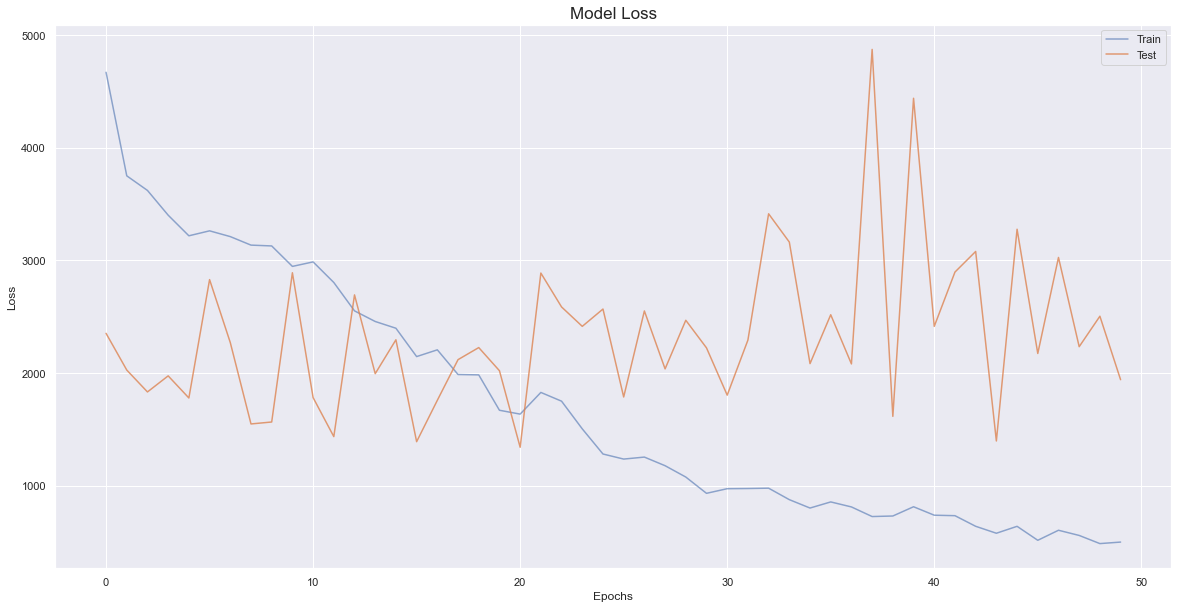

In [511]:
loss_plot(history_forecaster)

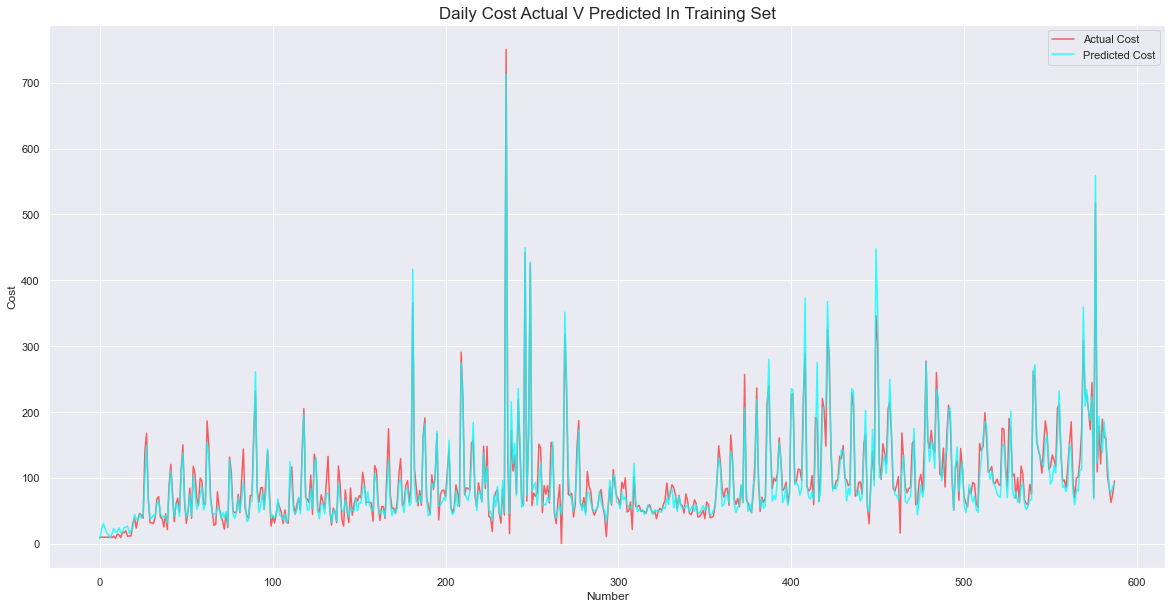

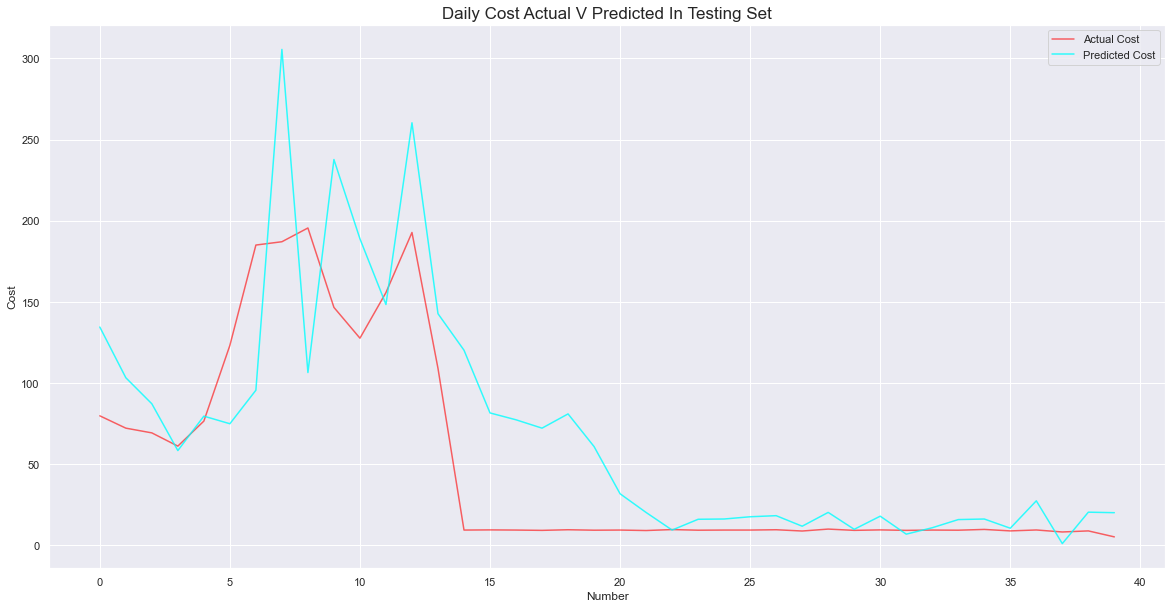

In [491]:
def actual_v_prediction_plot(X, y, forecaster, mode = "Training"):
    
    y_pred = forecaster.predict(X).reshape((y.shape[0], ))
    
    plt.figure(figsize = (20, 10))
    plt.plot(y, alpha = 0.6, c = "red")
    plt.plot(y_pred, alpha = 0.8, c = "cyan")
    plt.title("Daily Cost Actual V Predicted" + " In " + mode + " Set", fontsize = 17)
    plt.ylabel("Cost", fontsize = 12)
    plt.xlabel("Number", fontsize = 12)
    plt.legend(["Actual Cost", "Predicted Cost", "Outlier"], loc = "upper right")
    plt.show()
    
    
actual_v_prediction_plot(X_ensemble, y_train, lstm_forecaster)
actual_v_prediction_plot(X_test_ensemble, y_test, lstm_forecaster, mode = "Testing")

After building the LSTM Autoencoder and LSTM forecaster, model uncertainty is utilised to perform anomaly detection for daily cost. This metric can help us monitor our daily cost in different projects and products. The prediction for daily cost one day ahead can give us an early warning for any outlier in daily cost in the next day.

Many resources show that the use of dropout in neural networks can be interpreted as a Bayesian approximation of a Gaussian process, a well-known probabilistic model. Dropout is used in many models especially in deep learning as a tool to avoid over-fitting, and they show that dropout approximately integrates over the models' weights. According to this, we will use <b>Monte Carlo Dropout</b> in our neural network to represent model uncertainty.

In terms of anomaly detection, given a well-performed neural network that has learnt the pattern of data quite well can provide a prediction along with a small confidence interval, <b>a prediction with greater confidence interval, namely, greater uncertatinty</b> means that our neural network does not have too many information or knowledge about it. These predictions are highly likely to be an anomaly.

In [544]:
# Build Monte Carlo Dropout Training

def stochastic_training(X, F, encoder, forecaster, mode = True, F_included = False):
    
    encoder_func = K.function([encoder.layers[0].input, K.symbolic_learning_phase()], [encoder.layers[-1].output])
    X_encoder = np.vstack(encoder_func([X, mode]))
    
    if F_included:
        X_encoder = np.concatenate([X_encoder, X, F], axis = 2)
    else:
        X_encoder = np.concatenate([X_encoder, X], axis = 2)
    
    forecaster_func = K.function(
        [forecaster.layers[0].input, K.symbolic_learning_phase()], 
        [forecaster.layers[-1].output]
    )
    y_predict = forecaster_func([X_encoder, mode])
    y_predict = np.vstack(y_predict)
    
    return y_predict

def stochastic_training_keras(X, F, y, encoder, forecaster, F_included = False):
    
    X_encoder = encoder.predict(X)
    if F_included:
        X_encoder = np.concatenate([X_encoder, X, F], axis = 2)
    else:
        X_encoder = np.concatenate([X_encoder, X], axis = 2)
    y_predict = forecaster.predict(X_encoder)
    
    return y_predict

In [605]:
# Running Monte Carlo Dropout for Training Set
y_estimate = []
mape_train = []
mse_train = []
mae_train = []
for i in tqdm.tqdm(range(0, 500)):
    y_est = stochastic_training(X_train, F_train, lstm_encoder, lstm_forecaster)
    mape = np.mean(np.abs(y_est - y_train) / y_train)
    mse = np.mean((y_est - y_train) ** 2)
    mae = np.mean(np.abs(y_est - y_train))
    y_estimate.append(y_est)
    mape_train.append(mape)
    mse_train.append(mse)
    mae_train.append(mae)

100%|██████████| 500/500 [03:32<00:00,  2.35it/s]


In [603]:
y_estimate = np.asarray(y_estimate)[:,:,0]
y_estimate_quantile_large = np.quantile(y_estimate, 0.9, axis = 0)
y_estimate_quantile_small = np.quantile(y_estimate, 0.1, axis = 0)
y_estimate_median = np.quantile(y_estimate, 0.5, axis = 0)
y_estimate_mean = np.asarray([np.mean(y_estimate[:, _]) for _ in range(y_estimate.shape[1])])
y_estimate_diff = y_estimate_quantile_large - y_estimate_quantile_small

anomaly = pd.DataFrame({
    "Actual": y_train.reshape((588, )),
    "Estimated": y_estimate_mean,
    "Uncertainty Bound": y_estimate_diff.reshape((588, ))
})

# Uncertainty Bound Over Specific Threshold
anomaly["Outlier"] = anomaly["Uncertainty Bound"] > np.quantile(y_estimate_diff, 0.95)
anomaly_set = anomaly.loc[anomaly.Outlier == True]

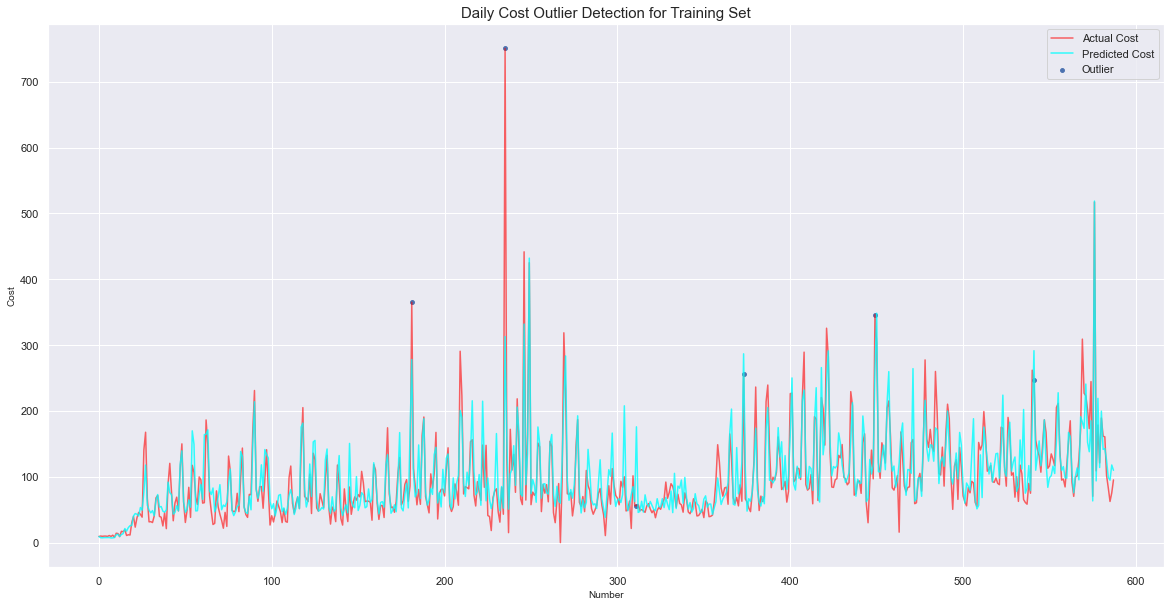

In [604]:
def anomaly_plot(y_pred, y, anomaly):
    
    plt.figure(figsize = (20, 10))
    plt.plot(y, alpha = 0.6, c = "red") 
    plt.plot(y_pred, alpha = 0.8, c = "cyan")
    plt.scatter(anomaly.index, anomaly_set.Actual, s = 15)
    plt.title("Daily Cost Outlier Detection for Training Set", fontsize = 15)
    plt.ylabel("Cost", fontsize = 10)
    plt.xlabel("Number", fontsize = 10)
    plt.legend(["Actual Cost", "Predicted Cost", "Outlier"], loc = "upper right")
    plt.show()
    
anomaly_plot(y_estimate_mean, y_train, anomaly_set)

Our model can detect almost all the relative high daily cost in the past, so this model perform quite well in this project.

<Figure size 1080x576 with 0 Axes>

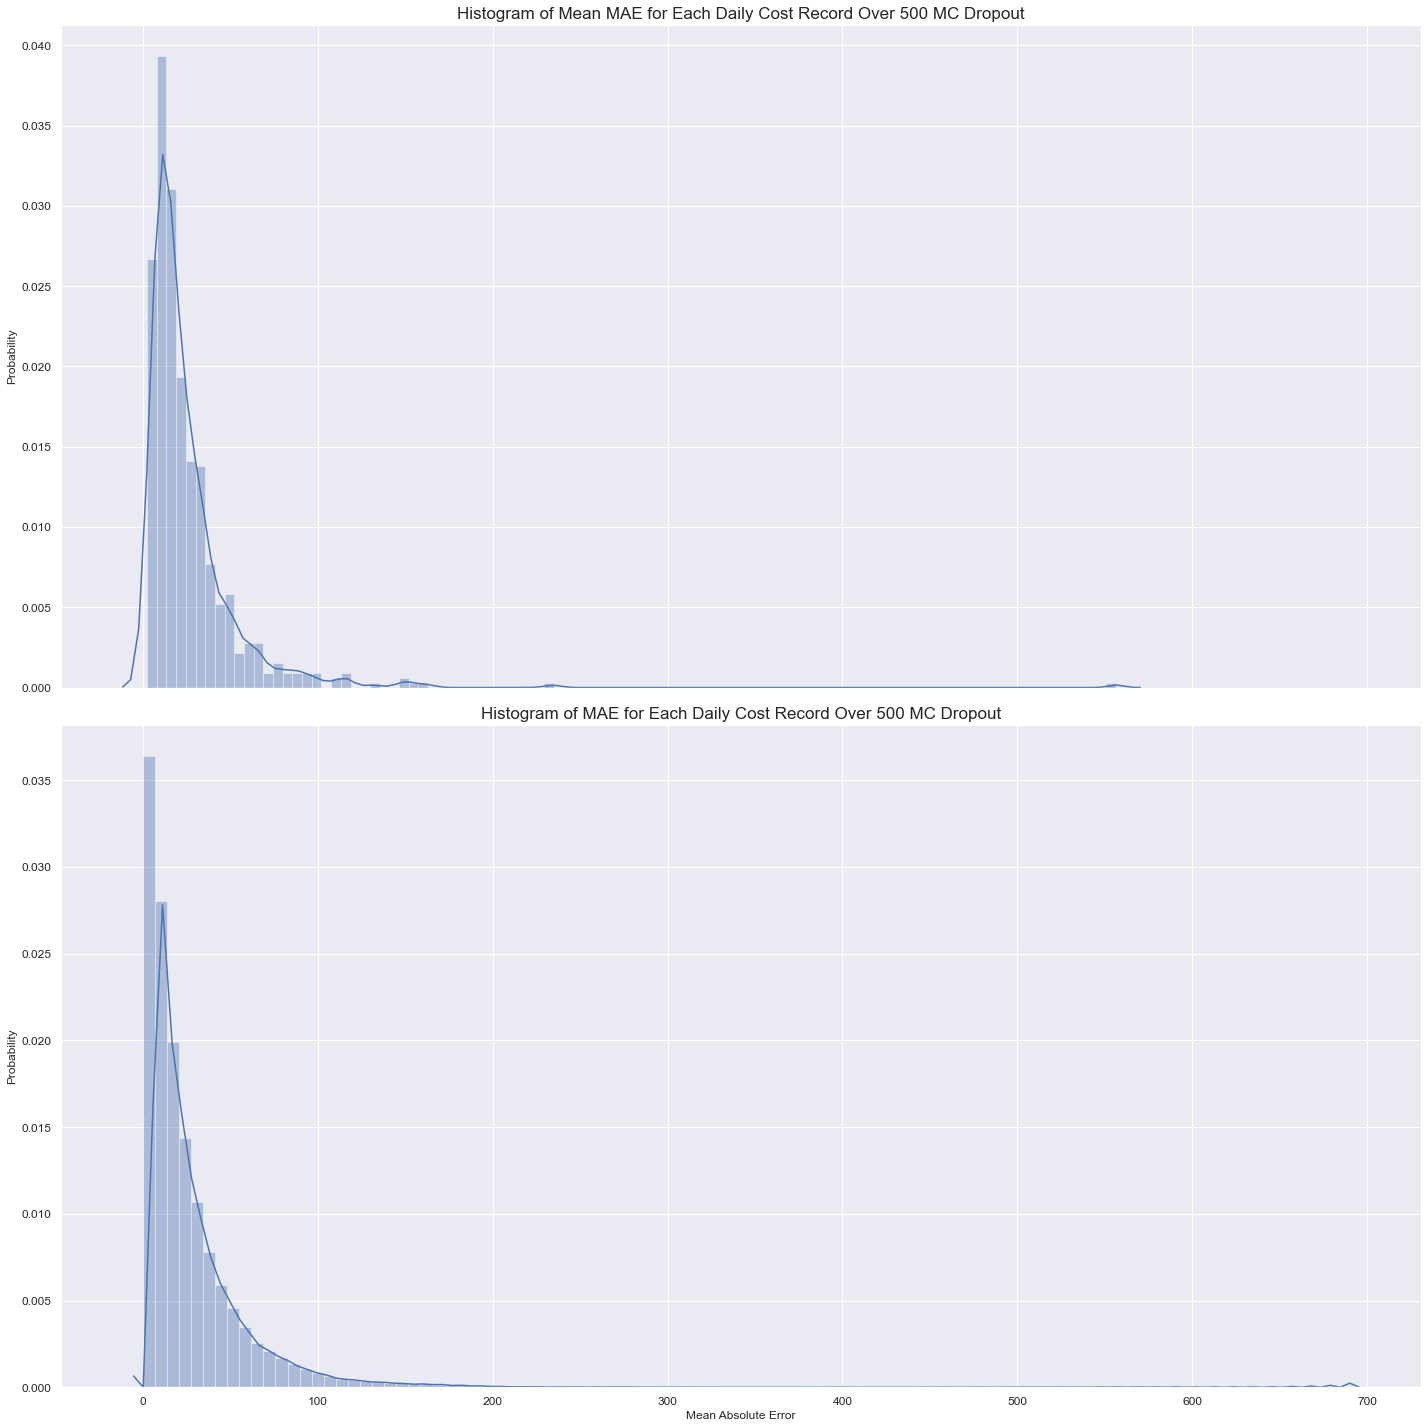

In [475]:
fig_size = [20, 20]
fig = plt.figure()
fig, axes = plt.subplots(2, 1, sharex = True, figsize = fig_size)
    
sns.distplot(
    [np.mean(mae_train[x,:]) for x in range(588)], bins = 100, kde = True, ax = axes[0]
)
sns.distplot(
    mae_train.reshape(588*500,1), bins = 100, kde = True, ax = axes[1]
)
axes[0].set_title("Histogram of Mean MAE for Each Daily Cost Record Over 500 MC Dropout", fontsize = 17)
axes[0].set_ylabel("Probability", fontsize = 12)
axes[0].tick_params(labelsize = 12)
axes[1].set_title("Histogram of MAE for Each Daily Cost Record Over 500 MC Dropout", fontsize = 17)
axes[1].set_ylabel("Probability", fontsize = 12)
axes[1].tick_params(labelsize = 12)
axes[1].set_xlabel("Mean Absolute Error", fontsize = 12)
fig.tight_layout()

In [477]:
# Running Monte Carlo Dropout for Testing Set
y_pred = []
for i in tqdm.tqdm(range(0, 500)):
    y_pred.append(stochastic_training(
        X_test, F_test, lstm_encoder, lstm_forecaster, mode = False
    )) # mode = False for testing

100%|██████████| 500/500 [02:50<00:00,  2.93it/s]


In [480]:
# y_pred = np.asarray(y_pred)[:,:,0]
y_pred_quantile_large = np.quantile(y_pred, 0.9, axis = 0)
y_pred_quantile_small = np.quantile(y_pred, 0.1, axis = 0)
y_pred_median = np.quantile(y_pred, 0.5, axis = 0)
y_pred_mean = np.asarray([np.mean(y_pred[:, _]) for _ in range(y_pred.shape[1])])
y_pred_diff = y_pred_quantile_large - y_pred_quantile_small

anomaly_pred = pd.DataFrame({
    "Actual": y_test.reshape((40, )),
    "10% Quantile": y_pred_quantile_small,
    "Estimated": y_pred_median,
    "90% Quantile": y_pred_quantile_large,
    "Uncertainty Bound": y_pred_diff.reshape((40, ))
})
anomaly_pred["Outlier"] = anomaly_pred["Uncertainty Bound"] > 84
anomaly_pred_set = anomaly_pred.loc[anomaly_pred.Outlier == True]

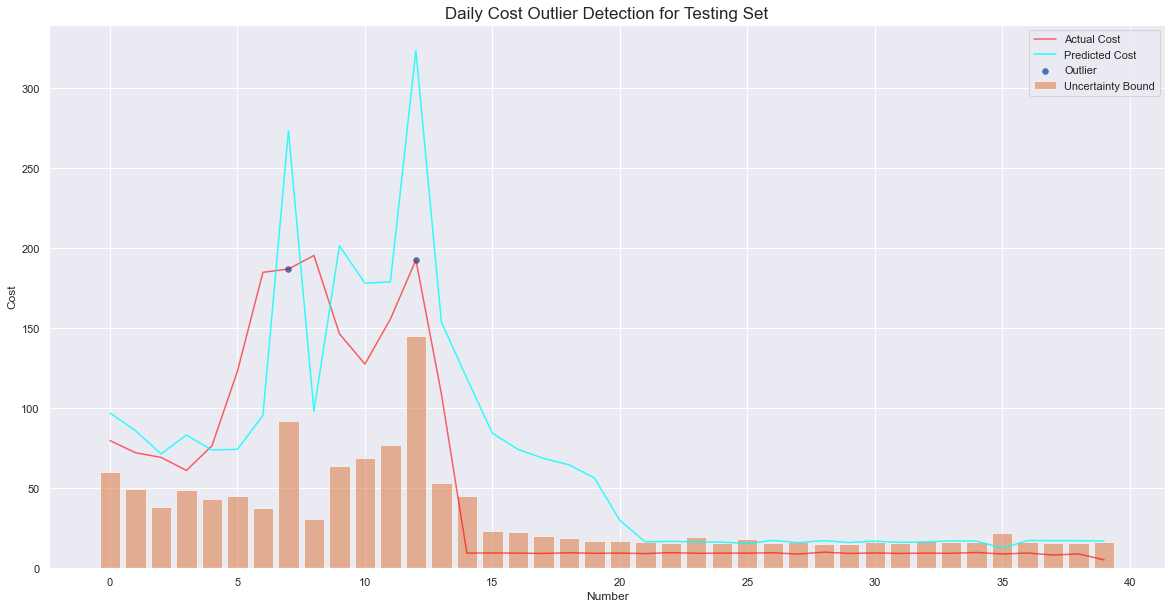

In [484]:
plt.figure(figsize = (20, 10))
plt.plot(y_test, alpha = 0.6, c = "red") 
plt.plot(y_pred_median, alpha = 0.8, c = "cyan")
plt.scatter(anomaly_pred_set.index, anomaly_pred_set.Actual, s = 30)
plt.bar(np.arange(0, 40, 1), anomaly_pred["Uncertainty Bound"], alpha = 0.6)
plt.title("Daily Cost Outlier Detection for Testing Set", fontsize = 17)
plt.ylabel("Cost", fontsize = 12)
plt.xlabel("Number", fontsize = 12)
plt.legend(["Actual Cost", "Predicted Cost", "Outlier", "Uncertainty Bound"], loc = "upper right")
plt.show()

After applying our model to testing data, two outliers have been detected. But it fails to capture the highest daily cost in these 35 days. 

The model shown in the below is a simple encoder-decoder LSTM neural network, which only use the previous daily cost in pre-defined shifted window to predict future cost rather than including the extra features generated from encoder. Compared to the final loss metric, we can see a significant increase from a simple LSTM (3399) to a two-step LSTM (629).

In [485]:
# Encoder and Decoder LSTM
def build_model(X_train, y_train, X_test, y_test):
    
    epochs, batch_size = 30, 5
    num_timestamps, num_features, num_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(512, activation = "relu", input_shape = (num_timestamps, num_features), return_sequences = True))
    model.add(LSTM(256, activation = "relu", return_sequences = True))
    model.add(LSTM(128, activation = "relu", return_sequences = True))
    model.add(LSTM(64, activation = "relu"))
    model.add(RepeatVector(num_outputs))
    # model.add(
        # tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = "relu", 
                               # input_shape = (num_timestamps, num_features))
    # )
    # model.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = "relu"))
    # model.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
    # model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.RepeatVector(num_outputs))
    model.add(LSTM(400, activation = "relu", return_sequences = True))
    model.add(LSTM(200, activation = "relu", return_sequences = True))
    model.add(TimeDistributed(tf.keras.layers.Dense(200, activation = "relu")))
    model.add(TimeDistributed(tf.keras.layers.Dense(1)))
    model.compile(loss = "mean_squared_error", optimizer = RMSprop(learning_rate = 0.000003))
    history = model.fit(
        X_train, y_train, validation_data = (X_test, y_test), 
        epochs = epochs, batch_size = batch_size
    )
    
    return model, history

In [486]:
model, history = build_model(X_train, y_train, X_test, y_test)

Train on 588 samples, validate on 40 samples
Epoch 1/30
588/588 [==============================] - 9s 16ms/sample - loss: 14115.9167 - val_loss: 6549.4800
Epoch 2/30
588/588 [==============================] - 5s 8ms/sample - loss: 14109.2655 - val_loss: 6546.6116
Epoch 3/30
588/588 [==============================] - 4s 8ms/sample - loss: 14089.1454 - val_loss: 6538.1042
Epoch 4/30
588/588 [==============================] - 5s 8ms/sample - loss: 14038.1897 - val_loss: 6517.1017
Epoch 5/30
588/588 [==============================] - 4s 8ms/sample - loss: 13933.0929 - val_loss: 6474.8237
Epoch 6/30
588/588 [==============================] - 5s 8ms/sample - loss: 13741.5846 - val_loss: 6381.9940
Epoch 7/30
588/588 [==============================] - 4s 8ms/sample - loss: 13353.9902 - val_loss: 6196.2353
Epoch 8/30
588/588 [==============================] - 4s 8ms/sample - loss: 12788.8089 - val_loss: 5912.3482
Epoch 9/30
588/588 [==============================] - 5s 8ms/sample - loss: 11999.

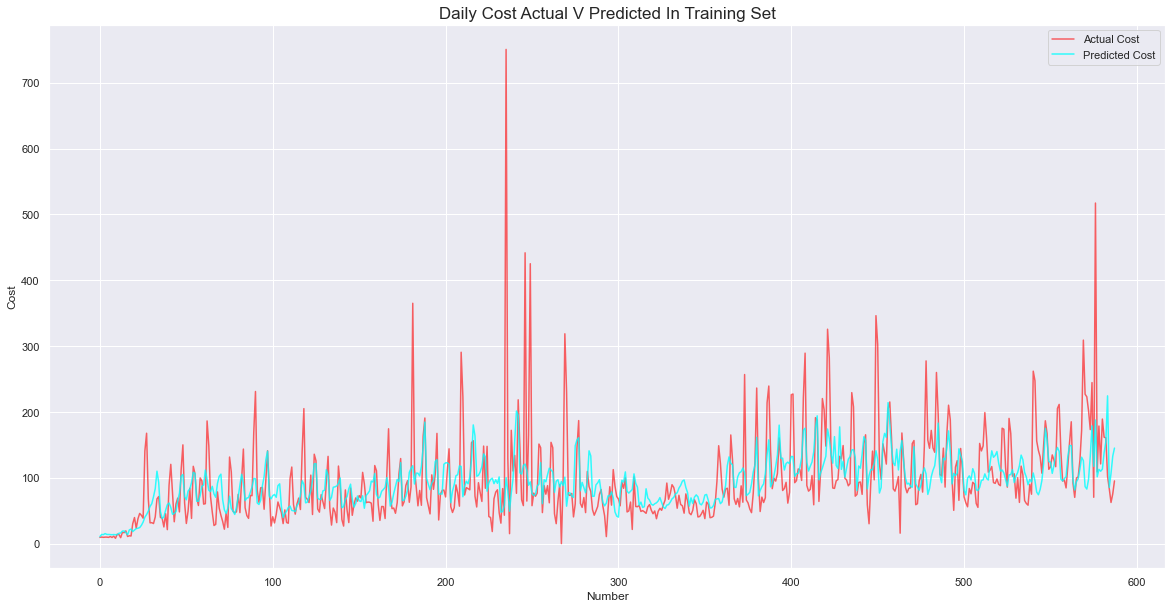

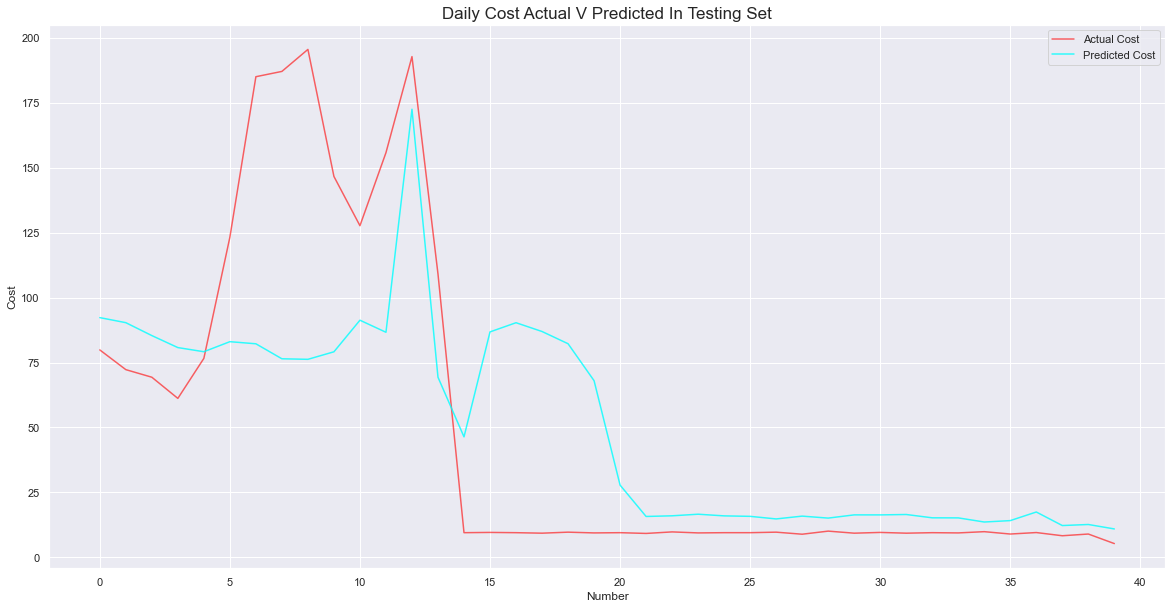

In [505]:
actual_v_prediction_plot(X_train, y_train, model)
actual_v_prediction_plot(X_test, y_test, model, mode = "Testing")